In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
# Veri işleme
import pandas as pd
import numpy as np
import re
import ast
import json
from collections import defaultdict
from itertools import combinations

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Ön işleme
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler

# Sklearn - Modelleme
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, train_test_split, cross_val_score

# XGBoost
import xgboost as xgb

# PyTorch
import torch

# Optimizasyon
import optuna
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
!git clone https://github.com/Abmn0/emlak_dataset.git

Cloning into 'emlak_dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 3.10 MiB | 3.68 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
processed_df = pd.read_csv("emlak_dataset/hazir_veri_seti.csv") #hazırlanmış veri seti ile çalışıyoruz

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

def run_xgboost_model(
    optuna_enabled=False,
    n_splits=5,
    random_state=42,
    n_trials=40
):

    # Hedef ve özellik sütunlarını belirleme
    target_column = 'housingComplex'
    if target_column not in processed_df.columns:
        raise ValueError("processed_df'de 'housingComplex' sütunu bulunamadı.")

    # Özellik sütunlarını belirle, 'listingId' sütununu hariç tut
    feature_columns = [col for col in processed_df.columns if col not in [target_column, 'listingId']]

    # Özellik sütunlarının veri tiplerini kontrol et
    invalid_columns = []
    for col in feature_columns:
        if processed_df[col].dtype not in ['int64', 'float64', 'bool', 'category']:
            invalid_columns.append(col)
    if invalid_columns:
        raise ValueError(
            f"Geçersiz veri tipleri tespit edildi. XGBoost sadece int, float, bool veya category türlerini destekler. "
            f"Geçersiz sütunlar: {invalid_columns}"
        )

    # Sınıf frekanslarını kontrol et
    class_counts = processed_df[target_column].value_counts()
    print("Sınıf frekansları:\n", class_counts)

    # Eğitim verileri
    X = processed_df[feature_columns]
    y = processed_df[target_column]

    # scale_pos_weight hesaplama
    scale_pos_weight = sum(y == 0) / sum(y == 1)
    print(f"scale_pos_weight: {scale_pos_weight:.4f}")

    # Varsayılan model parametreleri
    default_params = {
        'objective': 'binary:logistic',
        'eta': 0.1,
        'max_depth': 6,
        'n_estimators': 1000,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'gamma': 0,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': random_state,
        'eval_metric': 'auc',
        'scale_pos_weight': scale_pos_weight
    }

    # Optuna ile hiperparametre optimizasyonu
    if optuna_enabled:
        def objective(trial):
            optuna_params = {
                'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'objective': 'binary:logistic',
                'random_state': random_state,
                'eval_metric': 'auc',
                'scale_pos_weight': scale_pos_weight
            }

            # Çapraz doğrulama
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            mcc_scores = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = xgb.XGBClassifier(**optuna_params)
                model.fit(X_train, y_train, verbose=False)

                y_pred = model.predict(X_test)
                mcc_scores.append(matthews_corrcoef(y_test, y_pred))

            return np.mean(mcc_scores)

        # Optuna çalıştır
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        best_params.update({
            'objective': 'binary:logistic',
            'random_state': random_state,
            'eval_metric': 'auc',
            'scale_pos_weight': scale_pos_weight
        })
        print("En iyi parametreler:", best_params)
        model_params = best_params
    else:
        model_params = default_params

    # Çapraz doğrulama
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracy_scores, f1_scores, mcc_scores, auc_scores = [], [], [], []
    confusion_matrices = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Model eğitimi
        xgb_model = xgb.XGBClassifier(**model_params)
        xgb_model.fit(X_train, y_train, verbose=False)

        # Tahmin
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        # Metrikler
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        mcc_scores.append(matthews_corrcoef(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_pred_proba))

        # Konfüzyon matrisi
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

    # Ortalama konfüzyon matrisi
    avg_cm = np.mean(confusion_matrices, axis=0).astype(int)
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Ortalama Konfüzyon Matrisi (5 Katlı Çapraz Doğrulama)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()
    plt.close()

    # Ortalama CV skorları
    print("5 Katlı Çapraz Doğrulama Ortalama Skorları:")
    print(f"Ortalama Doğruluk: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"Ortalama F1 Skoru: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Ortalama MCC: {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}")
    print(f"Ortalama AUC-ROC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

    # CV skorlarını DataFrame'e kaydet
    cv_results_df = pd.DataFrame({
        'Accuracy': [np.mean(accuracy_scores)],
        'F1 Score': [np.mean(f1_scores)],
        'MCC': [np.mean(mcc_scores)],
        'AUC-ROC': [np.mean(auc_scores)]
    }, index=['xgboost'])

    return cv_results_df

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def run_knn_model_realistic(
    df,
    target_column='housingComplex',
    n_splits=5,
    random_state=42,
    optuna_enabled=False,
    n_trials=40
):
    # Hedef sütunu kontrol et
    if target_column not in df.columns:
        raise ValueError(f"df'de '{target_column}' sütunu bulunamadı.")

    # Özellik sütunlarını belirle, 'listingId' sütununu hariç tut
    feature_columns = [col for col in df.columns if col not in [target_column, 'listingId']]

    # Özellik sütunlarının veri tiplerini kontrol et
    invalid_columns = []
    for col in feature_columns:
        if df[col].dtype not in ['int64', 'float64', 'bool', 'category']:
            invalid_columns.append(col)
    if invalid_columns:
        raise ValueError(
            f"Geçersiz veri tipleri tespit edildi. KNN sadece int, float, bool veya category türlerini destekler. "
            f"Geçersiz sütunlar: {invalid_columns}"
        )

    # Sınıf frekanslarını kontrol et
    class_counts = df[target_column].value_counts()
    print("Sınıf frekansları:\n", class_counts)

    # Eğitim verileri
    X = df[feature_columns]
    y = df[target_column]

    # Optuna ile hiperparametre optimizasyonu
    if optuna_enabled:
        def objective(trial):
            optuna_params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 3, 25),
                'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
            }

            # Çapraz doğrulama
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            mcc_scores = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                model = KNeighborsClassifier(**optuna_params)
                model.fit(X_train_scaled, y_train)

                y_pred = model.predict(X_test_scaled)
                mcc_scores.append(matthews_corrcoef(y_test, y_pred))

            return np.mean(mcc_scores)

        # Optuna çalıştır
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        print("En iyi parametreler:", best_params)
    else:
        best_params = {'n_neighbors': 5, 'metric': 'minkowski'}

    # Çapraz doğrulama
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracy_scores, f1_scores, mcc_scores, auc_scores = [], [], [], []
    confusion_matrices = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Ölçeklendirme
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Model eğitimi
        model = KNeighborsClassifier(**best_params)
        model.fit(X_train_scaled, y_train)

        # Tahmin
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Metrikler
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        mcc_scores.append(matthews_corrcoef(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_pred_proba))

        # Konfüzyon matrisi
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

    # Ortalama konfüzyon matrisi
    avg_cm = np.mean(confusion_matrices, axis=0).astype(int)
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Ortalama Konfüzyon Matrisi (5 Katlı Çapraz Doğrulama)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()
    plt.close()

    # Ortalama CV skorları
    print("5 Katlı Çapraz Doğrulama Ortalama Skorları:")
    print(f"Ortalama Doğruluk: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"Ortalama F1 Skoru: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Ortalama MCC: {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}")
    print(f"Ortalama AUC-ROC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

    # CV skorlarını DataFrame'e kaydet
    cv_results_df = pd.DataFrame({
        'Accuracy': [np.mean(accuracy_scores)],
        'F1 Score': [np.mean(f1_scores)],
        'MCC': [np.mean(mcc_scores)],
        'AUC-ROC': [np.mean(auc_scores)]
    }, index=['knn'])

    return cv_results_df

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def run_svm_model(
    df,
    target_column='housingComplex',
    n_splits=5,
    random_state=42,
    optuna_enabled=False,
    n_trials=7
):
    # Hedef sütunu kontrol et
    if target_column not in df.columns:
        raise ValueError(f"df'de '{target_column}' sütunu bulunamadı.")

    # Özellik sütunlarını belirle, 'listingId' sütununu hariç tut
    feature_columns = [col for col in df.columns if col not in [target_column, 'listingId']]

    # Özellik sütunlarının veri tiplerini kontrol et
    invalid_columns = []
    for col in feature_columns:
        if df[col].dtype not in ['int64', 'float64', 'bool', 'category']:
            invalid_columns.append(col)
    if invalid_columns:
        raise ValueError(
            f"Geçersiz veri tipleri tespit edildi. SVM sadece int, float, bool veya category türlerini destekler. "
            f"Geçersiz sütunlar: {invalid_columns}"
        )

    # Sınıf frekanslarını kontrol et
    class_counts = df[target_column].value_counts()
    print("Sınıf frekansları:\n", class_counts)

    # Eğitim verileri
    X = df[feature_columns]
    y = df[target_column]

    # Optuna ile hiperparametre optimizasyonu
    if optuna_enabled:
      def objective(trial):
          optuna_params = {
              'C': trial.suggest_float('C', 0.1, 10.0, log=True),
              'kernel': 'linear',
              'random_state': random_state,
              'probability': True
          }
          kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
          mcc_scores = []
          for train_index, test_index in kf.split(X):
              X_train, X_test = X.iloc[train_index], X.iloc[test_index]
              y_train, y_test = y.iloc[train_index], y.iloc[test_index]
              scaler = StandardScaler()
              X_train_scaled = scaler.fit_transform(X_train)
              X_test_scaled = scaler.transform(X_test)
              model = SVC(**optuna_params)
              model.fit(X_train_scaled, y_train)
              y_pred = model.predict(X_test_scaled)
              mcc_scores.append(matthews_corrcoef(y_test, y_pred))
          return np.mean(mcc_scores)

      # Benzersiz bir study_name kullanarak study oluştur
      study_name = f"svm_study_{np.random.randint(10000)}"  # Her çalıştırmada benzersiz bir isim
      study = optuna.create_study(direction='maximize', study_name=study_name)
      study.optimize(objective, n_trials=n_trials)
      best_params = study.best_params
      best_params['random_state'] = random_state
      best_params['probability'] = True
      print("En iyi parametreler:", best_params)
    else:
        best_params = {
            'C': 1.0,
            'kernel': 'linear',  # Varsayılan olarak linear kernel
            'random_state': random_state,
            'probability': True
        }

    # Çapraz doğrulama
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracy_scores, f1_scores, mcc_scores, auc_scores = [], [], [], []
    confusion_matrices = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Ölçeklendirme
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Model eğitimi
        model = SVC(**best_params)
        model.fit(X_train_scaled, y_train)

        # Tahmin
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Metrikler
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        mcc_scores.append(matthews_corrcoef(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_pred_proba))

        # Konfüzyon matrisi
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

    # Ortalama konfüzyon matrisi
    avg_cm = np.mean(confusion_matrices, axis=0).astype(int)
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Ortalama Konfüzyon Matrisi (5 Katlı Çapraz Doğrulama)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()
    plt.close()

    # Ortalama CV skorları
    print("5 Katlı Çapraz Doğrulama Ortalama Skorları:")
    print(f"Ortalama Doğruluk: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"Ortalama F1 Skoru: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Ortalama MCC: {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}")
    print(f"Ortalama AUC-ROC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

    # CV skorlarını DataFrame'e kaydet
    cv_results_df = pd.DataFrame({
        'Accuracy': [np.mean(accuracy_scores)],
        'F1 Score': [np.mean(f1_scores)],
        'MCC': [np.mean(mcc_scores)],
        'AUC-ROC': [np.mean(auc_scores)]
    }, index=['svm'])

    return cv_results_df

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_logistic_regression_model(
    df,
    target_column='housingComplex',
    n_splits=5,
    random_state=42,
    optuna_enabled=False,
    n_trials=30
):
    # Hedef sütunu kontrol et
    if target_column not in df.columns:
        raise ValueError(f"df'de '{target_column}' sütunu bulunamadı.")

    # Özellik sütunlarını belirle, 'listingId' sütununu hariç tut
    feature_columns = [col for col in df.columns if col not in [target_column, 'listingId']]

    # Özellik sütunlarının veri tiplerini kontrol et
    invalid_columns = []
    for col in feature_columns:
        if df[col].dtype not in ['int64', 'float64', 'bool', 'category']:
            invalid_columns.append(col)
    if invalid_columns:
        raise ValueError(
            f"Geçersiz veri tipleri tespit edildi. Logistic Regression sadece int, float, bool veya category türlerini destekler. "
            f"Geçersiz sütunlar: {invalid_columns}"
        )

    # Sınıf frekanslarını kontrol et
    class_counts = df[target_column].value_counts()
    print("Sınıf frekansları:\n", class_counts)

    # Eğitim verileri
    X = df[feature_columns]
    y = df[target_column]

    # Veri ölçeklendirme
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_columns, index=X.index)

    # Optuna ile hiperparametre optimizasyonu
    if optuna_enabled:
        def objective(trial):
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
            solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])

            # Geçersiz kombinasyonları atla
            if penalty == 'l1' and solver != 'liblinear':
                raise optuna.exceptions.TrialPruned()
            if penalty == 'l2' and solver not in ['liblinear', 'lbfgs']:
                raise optuna.exceptions.TrialPruned()

            optuna_params = {
                'penalty': penalty,
                'C': trial.suggest_float('C', 0.01, 10.0, log=True),
                'solver': solver,
                'max_iter': 1000,
                'tol': trial.suggest_float('tol', 1e-5, 1e-3, log=True),
                'random_state': random_state
            }

            # Çapraz doğrulama
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            mcc_scores = []

            for train_index, test_index in kf.split(X_scaled):
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = LogisticRegression(**optuna_params)
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    mcc_scores.append(matthews_corrcoef(y_test, y_pred))
                except:
                    raise optuna.exceptions.TrialPruned()

            return np.mean(mcc_scores)

        # Optuna çalıştır
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials, n_jobs=1)  # n_jobs=1 to avoid parallel issues
        best_params = study.best_params
        best_params['max_iter'] = 1000
        best_params['random_state'] = random_state
        print("En iyi parametreler:", best_params)
    else:
        best_params = {
            'penalty': 'l2',
            'C': 1.0,
            'solver': 'lbfgs',
            'max_iter': 1000,
            'tol': 1e-4,
            'random_state': random_state
        }

    # Çapraz doğrulama
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracy_scores, f1_scores, mcc_scores, auc_scores = [], [], [], []
    confusion_matrices = []

    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Model eğitimi
        model = LogisticRegression(**best_params)
        model.fit(X_train, y_train)

        # Tahmin
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Metrikler
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        mcc_scores.append(matthews_corrcoef(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_pred_proba))

        # Konfüzyon matrisi
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

    # Ortalama konfüzyon matrisi
    avg_cm = np.mean(confusion_matrices, axis=0).astype(int)
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Ortalama Konfüzyon Matrisi (5 Katlı Çapraz Doğrulama)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()
    plt.close()

    # Ortalama CV skorları
    print("5 Katlı Çapraz Doğrulama Ortalama Skorları:")
    print(f"Ortalama Doğruluk: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"Ortalama F1 Skoru: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Ortalama MCC: {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}")
    print(f"Ortalama AUC-ROC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

    # CV skorlarını DataFrame'e kaydet
    cv_results_df = pd.DataFrame({
        'Accuracy': [np.mean(accuracy_scores)],
        'F1 Score': [np.mean(f1_scores)],
        'MCC': [np.mean(mcc_scores)],
        'AUC-ROC': [np.mean(auc_scores)]
    }, index=['logreg'])

    return cv_results_df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

def run_random_forest_model(
    optuna_enabled=False,
    n_splits=5,
    random_state=42,
    n_trials=20
):
    # Hedef ve özellik sütunlarını belirleme
    target_column = 'housingComplex'
    if target_column not in processed_df.columns:
        raise ValueError("processed_df'de 'housingComplex' sütunu bulunamadı.")

    # Özellik sütunlarını belirle, 'listingId' sütununu hariç tut
    feature_columns = [col for col in processed_df.columns if col not in [target_column, 'listingId']]

    # Özellik sütunlarının veri tiplerini kontrol et
    invalid_columns = []
    for col in feature_columns:
        if processed_df[col].dtype not in ['int64', 'float64', 'bool', 'category']:
            invalid_columns.append(col)
    if invalid_columns:
        raise ValueError(
            f"Geçersiz veri tipleri tespit edildi. Random Forest sadece int, float, bool veya category türlerini destekler. "
            f"Geçersiz sütunlar: {invalid_columns}"
        )

    # Sınıf frekanslarını kontrol et
    class_counts = processed_df[target_column].value_counts()
    print("Sınıf frekansları:\n", class_counts)

    # Eğitim verileri
    X = processed_df[feature_columns]
    y = processed_df[target_column]

    # class_weight hesaplama (Random Forest için dengesiz sınıflar)
    class_weight = 'balanced' if sum(y == 0) != sum(y == 1) else None
    print(f"class_weight: {class_weight}")

    # Varsayılan model parametreleri
    default_params = {
        'n_estimators': 1000,
        'max_depth': 6,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True,
        'random_state': random_state,
        'class_weight': class_weight
    }

    # Optuna ile hiperparametre optimizasyonu
    if optuna_enabled:
        def objective(trial):
            optuna_params = {
                'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'random_state': random_state,
                'class_weight': class_weight
            }

            # Çapraz doğrulama
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            mcc_scores = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = RandomForestClassifier(**optuna_params)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)
                mcc_scores.append(matthews_corrcoef(y_test, y_pred))

            return np.mean(mcc_scores)

        # Optuna çalıştır
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        best_params.update({
            'random_state': random_state,
            'class_weight': class_weight
        })
        print("En iyi parametreler:", best_params)
        model_params = best_params
    else:
        model_params = default_params

    # Çapraz doğrulama
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracy_scores, f1_scores, mcc_scores, auc_scores = [], [], [], []
    confusion_matrices = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Model eğitimi
        rf_model = RandomForestClassifier(**model_params)
        rf_model.fit(X_train, y_train)

        # Tahmin
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        # Metrikler
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        mcc_scores.append(matthews_corrcoef(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_pred_proba))

        # Konfüzyon matrisi
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

    # Ortalama konfüzyon matrisi
    avg_cm = np.mean(confusion_matrices, axis=0).astype(int)
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Ortalama Konfüzyon Matrisi (5 Katlı Çapraz Doğrulama)')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()
    plt.close()

    # Ortalama CV skorları
    print("5 Katlı Çapraz Doğrulama Ortalama Skorları:")
    print(f"Ortalama Doğruluk: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"Ortalama F1 Skoru: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Ortalama MCC: {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}")
    print(f"Ortalama AUC-ROC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

    # CV skorlarını DataFrame'e kaydet
    cv_results_df = pd.DataFrame({
        'Accuracy': [np.mean(accuracy_scores)],
        'F1 Score': [np.mean(f1_scores)],
        'MCC': [np.mean(mcc_scores)],
        'AUC-ROC': [np.mean(auc_scores)]
    }, index=['random_forest'])

    return cv_results_df

OPTUNA KAPALI DEFAULT PARAMETRELERLE


OPTUNA AÇIK HİPER PARAMETRE OPTİMİZASYONU İLE

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64
scale_pos_weight: 4.4861


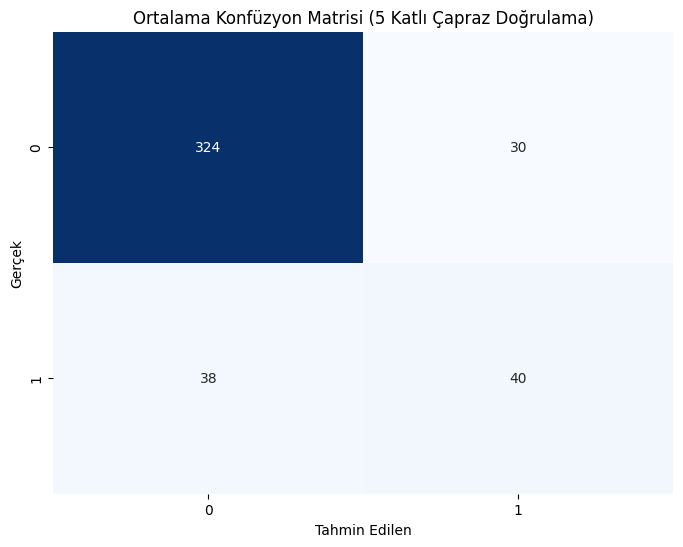

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8403 ± 0.0126
Ortalama F1 Skoru: 0.5378 ± 0.0286
Ortalama MCC: 0.4456 ± 0.0380
Ortalama AUC-ROC: 0.8435 ± 0.0233


In [ ]:
result_xgboost = run_xgboost_model(optuna_enabled=False)

[I 2025-05-20 17:03:29,110] A new study created in memory with name: no-name-b3cf560e-4cfc-44e8-bfcf-e4b714cadeb5


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64
scale_pos_weight: 4.4861


[I 2025-05-20 17:03:33,687] Trial 0 finished with value: 0.42880731058214616 and parameters: {'eta': 0.08496760755910747, 'max_depth': 10, 'n_estimators': 1219, 'subsample': 0.8778533801300714, 'colsample_bytree': 0.6556805077652412, 'min_child_weight': 3, 'gamma': 4.1361023956796865, 'reg_alpha': 4.017259800244009, 'reg_lambda': 4.436333821417422}. Best is trial 0 with value: 0.42880731058214616.
[I 2025-05-20 17:03:37,023] Trial 1 finished with value: 0.437643834792076 and parameters: {'eta': 0.0718368865531827, 'max_depth': 6, 'n_estimators': 830, 'subsample': 0.9268234406270266, 'colsample_bytree': 0.5771296171537967, 'min_child_weight': 6, 'gamma': 2.234696014812238, 'reg_alpha': 7.925077626626965, 'reg_lambda': 1.6569701521311686}. Best is trial 1 with value: 0.437643834792076.
[I 2025-05-20 17:03:45,933] Trial 2 finished with value: 0.4382241862593011 and parameters: {'eta': 0.12889956425561108, 'max_depth': 7, 'n_estimators': 1050, 'subsample': 0.5243408426124228, 'colsample_by

En iyi parametreler: {'eta': 0.045665066184786426, 'max_depth': 10, 'n_estimators': 597, 'subsample': 0.6662629371816596, 'colsample_bytree': 0.6829228123686255, 'min_child_weight': 2, 'gamma': 0.01787467989004754, 'reg_alpha': 2.022672889458245, 'reg_lambda': 3.905344395102541, 'objective': 'binary:logistic', 'random_state': 42, 'eval_metric': 'auc', 'scale_pos_weight': 4.4860759493670885}


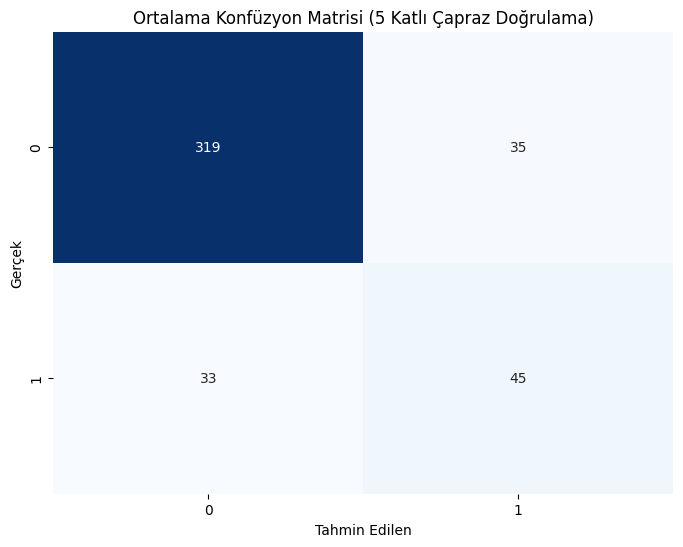

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8408 ± 0.0132
Ortalama F1 Skoru: 0.5683 ± 0.0334
Ortalama MCC: 0.4724 ± 0.0403
Ortalama AUC-ROC: 0.8565 ± 0.0181


In [ ]:
result_xgboost_optuna = run_xgboost_model(optuna_enabled=True)

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


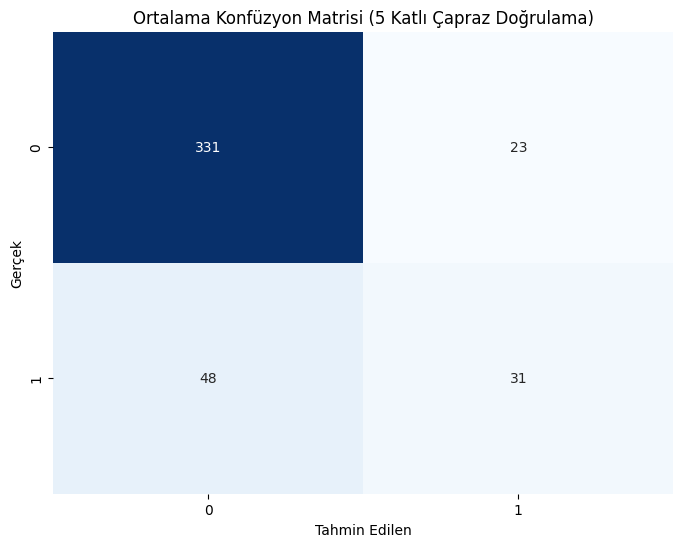

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8357 ± 0.0060
Ortalama F1 Skoru: 0.4646 ± 0.0171
Ortalama MCC: 0.3809 ± 0.0148
Ortalama AUC-ROC: 0.7802 ± 0.0218


In [ ]:
result_knn = run_knn_model_realistic(df=processed_df, optuna_enabled=False)

Model genel olarak iyi bir doğruluk sağlasa da, sınıf dengesizliği nedeniyle pozitif sınıfı (1) tahmin etmede zorluk yaşadık. F1 skoru ve MCC, modelin sınıf 1 için daha dengeli bir başarıya ihtiyaç duyduğunu gösteriyor. AUC değeri 0.78 ile oldukça iyi; bu da modelin sınıflar arasında ayrım yapabilme yeteneğinin makul olduğunu gösteriyor.


[I 2025-05-20 17:08:04,974] A new study created in memory with name: no-name-abd5420c-9890-4864-be9b-a0a4df46fe65


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


[I 2025-05-20 17:08:05,174] Trial 0 finished with value: 0.35669109106032604 and parameters: {'n_neighbors': 3, 'metric': 'minkowski'}. Best is trial 0 with value: 0.35669109106032604.
[I 2025-05-20 17:08:05,368] Trial 1 finished with value: 0.32180549987218415 and parameters: {'n_neighbors': 19, 'metric': 'minkowski'}. Best is trial 0 with value: 0.35669109106032604.
[I 2025-05-20 17:08:05,958] Trial 2 finished with value: 0.3044711048517081 and parameters: {'n_neighbors': 20, 'metric': 'manhattan'}. Best is trial 0 with value: 0.35669109106032604.
[I 2025-05-20 17:08:06,146] Trial 3 finished with value: 0.33670800419489993 and parameters: {'n_neighbors': 17, 'metric': 'minkowski'}. Best is trial 0 with value: 0.35669109106032604.
[I 2025-05-20 17:08:06,320] Trial 4 finished with value: 0.35669109106032604 and parameters: {'n_neighbors': 3, 'metric': 'minkowski'}. Best is trial 0 with value: 0.35669109106032604.
[I 2025-05-20 17:08:06,530] Trial 5 finished with value: 0.32750130441451

En iyi parametreler: {'n_neighbors': 7, 'metric': 'manhattan'}


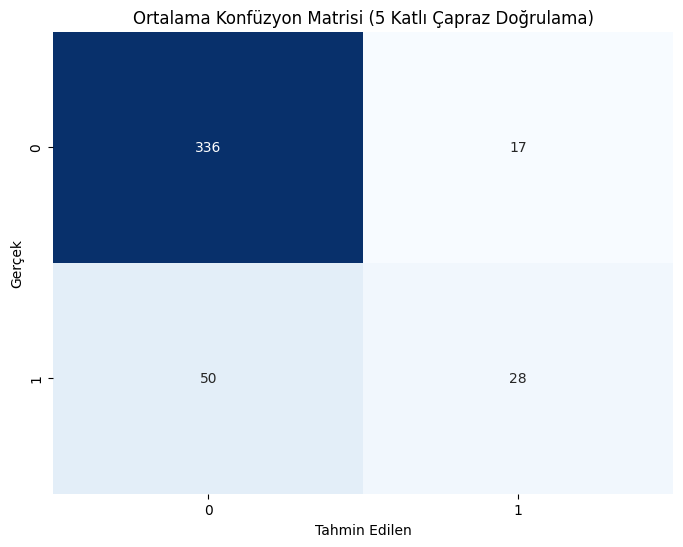

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8431 ± 0.0071
Ortalama F1 Skoru: 0.4534 ± 0.0510
Ortalama MCC: 0.3876 ± 0.0540
Ortalama AUC-ROC: 0.7948 ± 0.0260


In [ ]:
result_knn_optuna = run_knn_model_realistic(df=processed_df, optuna_enabled=True)

Bu modelde, temel KNN algoritmasına ek olarak, Optuna kütüphanesini kullanarak hiperparametre optimizasyonu eklendi. Yani burada, kaç komşu alınacağı ve hangi mesafe metriğinin kullanılacağı gibi önemli ayarlar, otomatik olarak en iyi sonuç verecek şekilde belirlendi.

Optimizasyon sonucunda özellikle MCC  katsayısında belirgin bir artış gözlemledndi. Bu değer yaklaşık 0.39’a çıktı ki, özellikle sınıflar arasında dengesizlik olan bir veri setinde oldukça anlamlı bir gelişme. Çünkü MCC, sınıf dengesizliklerinde modelin genel başarısını daha doğru yansıtan bir metrik.

Ayrıca, doğruluk oranı da önceki modele göre bir miktar arttı, yaklaşık yüzde 84 seviyelerine ulaştı. Ama sadece bu oran değil, aynı zamanda modelin genel davranışı da daha tutarlı hâle geldi.

Mesafe metriği olarak da Optuna'nın önerisiyle Manhattan metriği seçildi. Bu da modelin veri yapısına daha iyi uyum sağlamasına yardımcı oldu.

Genel olarak baktığımızda, bu optimize edilmiş model:

Daha yüksek başarı metriklerine sahip,

Daha az overfitting eğiliminde,

Ve en önemlisi, rastgele değil, sistematik şekilde geliştirilmiş bir model.

Yani bu model, önceki temel KNN modeline göre hem sayısal olarak hem de metodolojik olarak daha güçlü bir yaklaşım sunuyor.

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


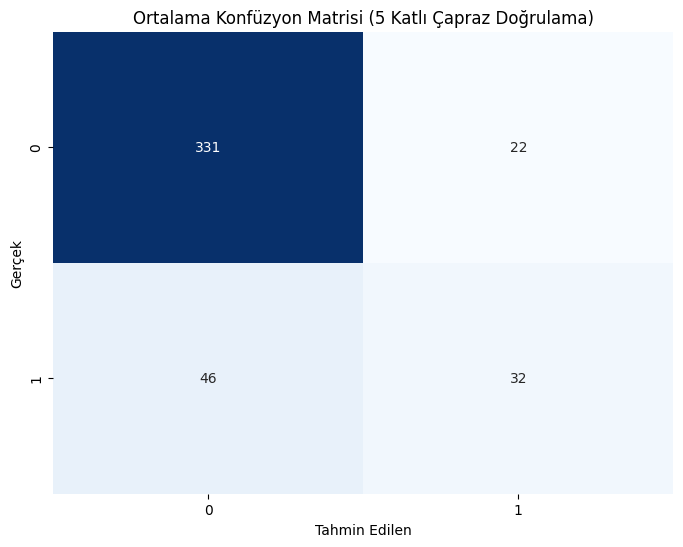

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8413 ± 0.0126
Ortalama F1 Skoru: 0.4873 ± 0.0452
Ortalama MCC: 0.4075 ± 0.0566
Ortalama AUC-ROC: 0.8175 ± 0.0227


In [ ]:
result_svm = run_svm_model(processed_df, optuna_enabled=False)

[I 2025-05-20 17:08:38,934] A new study created in memory with name: svm_study_3251


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


[I 2025-05-20 17:08:42,478] Trial 0 finished with value: 0.3972922647781313 and parameters: {'C': 0.14793703787749873}. Best is trial 0 with value: 0.3972922647781313.
[I 2025-05-20 17:08:51,857] Trial 1 finished with value: 0.4064104800218894 and parameters: {'C': 0.7012234966836653}. Best is trial 1 with value: 0.4064104800218894.
[I 2025-05-20 17:08:57,495] Trial 2 finished with value: 0.4073569293033753 and parameters: {'C': 0.35472544183478966}. Best is trial 2 with value: 0.4073569293033753.
[I 2025-05-20 17:09:03,231] Trial 3 finished with value: 0.4062875822398609 and parameters: {'C': 0.2620844293559719}. Best is trial 2 with value: 0.4073569293033753.
[I 2025-05-20 17:09:10,899] Trial 4 finished with value: 0.40978011851920704 and parameters: {'C': 0.5861319756759857}. Best is trial 4 with value: 0.40978011851920704.
[I 2025-05-20 17:09:17,370] Trial 5 finished with value: 0.4111506296294015 and parameters: {'C': 0.3611255647315128}. Best is trial 5 with value: 0.411150629629

En iyi parametreler: {'C': 0.3611255647315128, 'random_state': 42, 'probability': True}


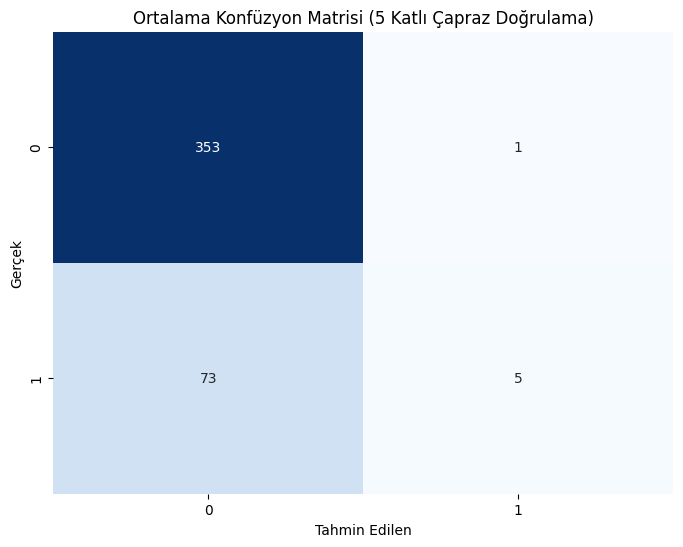

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8288 ± 0.0112
Ortalama F1 Skoru: 0.1343 ± 0.0338
Ortalama MCC: 0.2164 ± 0.0443
Ortalama AUC-ROC: 0.8283 ± 0.0132


In [ ]:
result_svm_optuna = run_svm_model(processed_df, optuna_enabled=True)

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


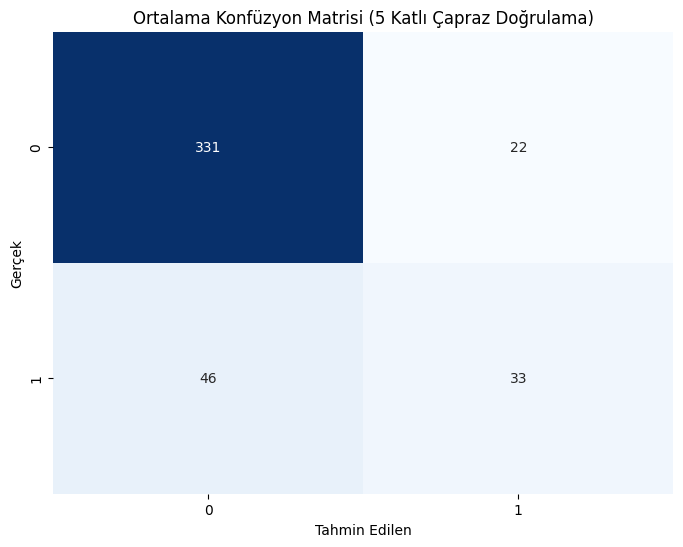

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8417 ± 0.0175
Ortalama F1 Skoru: 0.4900 ± 0.0547
Ortalama MCC: 0.4108 ± 0.0687
Ortalama AUC-ROC: 0.8322 ± 0.0180


In [ ]:
result_lr = run_logistic_regression_model(processed_df, optuna_enabled=False)

[I 2025-05-20 17:09:51,389] A new study created in memory with name: no-name-7804f8ce-6763-4d87-8adf-261c5db1b109
[I 2025-05-20 17:09:51,524] Trial 0 finished with value: 0.40420945176731615 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 5.773625151785029, 'tol': 0.00046583661213192286}. Best is trial 0 with value: 0.40420945176731615.
[I 2025-05-20 17:09:51,526] Trial 1 pruned. 


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


[I 2025-05-20 17:09:51,648] Trial 2 finished with value: 0.3910734749221422 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.023591889476427708, 'tol': 1.1965633324554384e-05}. Best is trial 0 with value: 0.40420945176731615.
[I 2025-05-20 17:09:51,653] Trial 3 pruned. 
[I 2025-05-20 17:09:51,931] Trial 4 finished with value: 0.4123885488049302 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 3.839764401697123, 'tol': 1.6393239405825866e-05}. Best is trial 4 with value: 0.4123885488049302.
[I 2025-05-20 17:09:52,099] Trial 5 finished with value: 0.349313260347021 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.06239425881267836, 'tol': 3.8082420599882816e-05}. Best is trial 4 with value: 0.4123885488049302.
[I 2025-05-20 17:09:52,322] Trial 6 finished with value: 0.39236724004393475 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.15103427605626915, 'tol': 0.00024703196795358674}. Best is trial 4 with value: 0.4123885488049302.
[I 2025

En iyi parametreler: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 2.220864122787552, 'tol': 0.00019338765044889881, 'max_iter': 1000, 'random_state': 42}


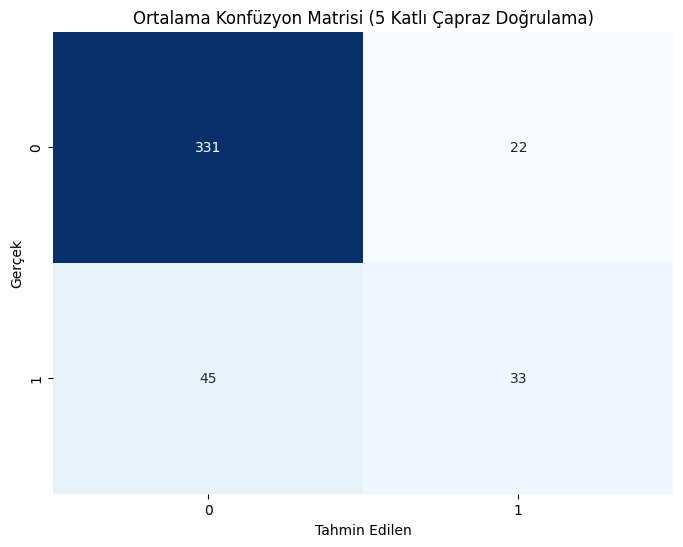

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8422 ± 0.0159
Ortalama F1 Skoru: 0.4938 ± 0.0500
Ortalama MCC: 0.4141 ± 0.0635
Ortalama AUC-ROC: 0.8315 ± 0.0182


In [ ]:
result_lr_optuna = run_logistic_regression_model(processed_df, optuna_enabled=True)

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64
class_weight: balanced


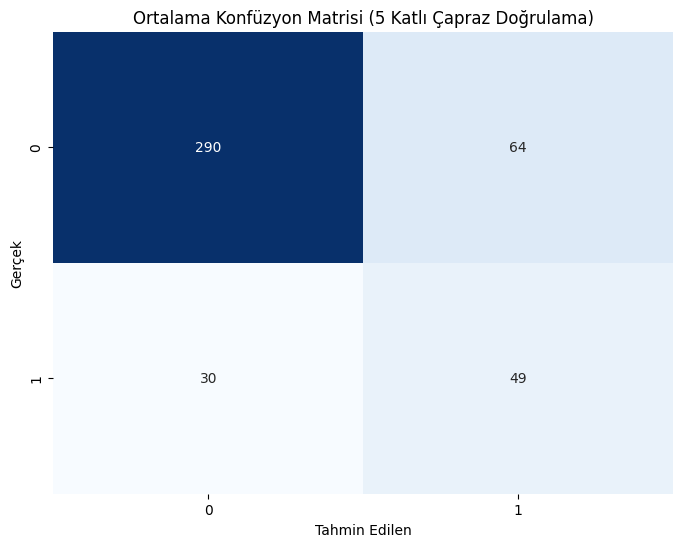

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.7826 ± 0.0165
Ortalama F1 Skoru: 0.5093 ± 0.0376
Ortalama MCC: 0.3856 ± 0.0457
Ortalama AUC-ROC: 0.8353 ± 0.0171


In [ ]:
result_rf = run_random_forest_model(optuna_enabled=False)

[I 2025-05-20 17:10:10,725] A new study created in memory with name: no-name-83c4485c-e59e-4e6b-a1a8-14e5d0d3af70


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64
class_weight: balanced


[I 2025-05-20 17:10:50,221] Trial 0 finished with value: 0.28439808793054605 and parameters: {'n_estimators': 1285, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.28439808793054605.
[I 2025-05-20 17:11:38,054] Trial 1 finished with value: 0.3281773932120323 and parameters: {'n_estimators': 923, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 0.3281773932120323.
[I 2025-05-20 17:11:50,051] Trial 2 finished with value: 0.42235840457327944 and parameters: {'n_estimators': 882, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.42235840457327944.
[I 2025-05-20 17:12:04,666] Trial 3 finished with value: 0.4257199466383213 and parameters: {'n_estimators': 389, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_feat

En iyi parametreler: {'n_estimators': 728, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True, 'random_state': 42, 'class_weight': 'balanced'}


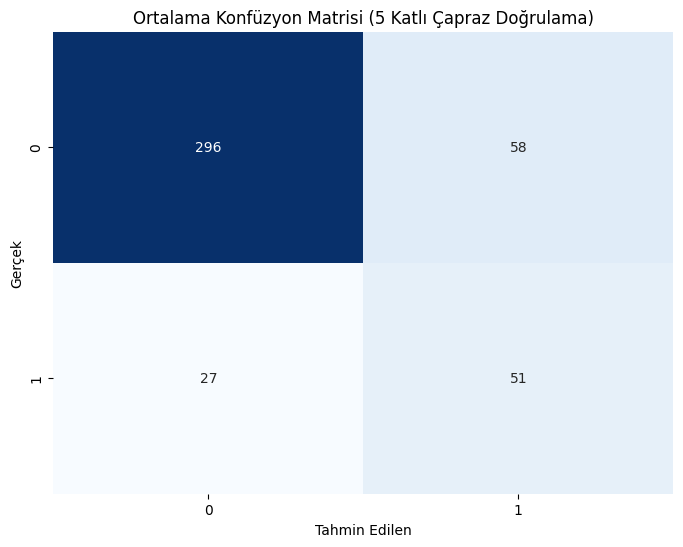

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8020 ± 0.0121
Ortalama F1 Skoru: 0.5457 ± 0.0234
Ortalama MCC: 0.4339 ± 0.0240
Ortalama AUC-ROC: 0.8545 ± 0.0074


In [ ]:
result_rf_optuna = run_random_forest_model(optuna_enabled=True)

ÖZELLİK MÜHENDİSLİĞİ

In [ ]:
# Özellik Mühendisliği Fonksiyonu
# 1. numeric_columns'dan housingComplex'i çıkar
numeric_columns = ['net', 'gross', 'room', 'attr_Açık Yüzme Havuzu', 'attr_Isı Yalıtım', 'onlineVisit']  # housingComplex çıkarılmış hali

def create_engineered_features(df, numeric_cols=None, log_threshold=1e-6):
    df = df.copy()

    # Sayısal sütunları seç
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # numeric_cols'un df'de mevcut olduğunu kontrol et
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    if not numeric_cols:
        raise ValueError("Hiçbir sayısal sütun bulunamadı veya belirtilen sütunlar veri setinde mevcut değil.")

    print(f"İşlenecek sayısal sütunlar ({len(numeric_cols)} adet): {numeric_cols}")

    new_features = {}

    # 2'li kombinasyonlar: çarpım, oran, toplam, fark
    for col1, col2 in combinations(numeric_cols, 2):
        new_features[f"{col1}_x_{col2}"] = df[col1] * df[col2]
        new_features[f"{col1}_div_{col2}"] = df[col1] / (df[col2] + log_threshold)
        new_features[f"{col1}_plus_{col2}"] = df[col1] + df[col2]
        new_features[f"{col1}_minus_{col2}"] = df[col1] - df[col2]

    # 3'lü kombinasyonlar: çarpım
    for col1, col2, col3 in combinations(numeric_cols, 3):
        new_features[f"{col1}_x_{col2}_x_{col3}"] = df[col1] * df[col2] * df[col3]

    # Tekil dönüşümler
    for col in numeric_cols:
        # Negatif veya sıfır değerler için kontrol
        new_features[f"log_{col}"] = np.log1p(df[col].clip(lower=0))
        new_features[f"sqrt_{col}"] = np.sqrt(df[col].clip(lower=0))
        mean = df[col].mean()
        std = df[col].std()
        new_features[f"zscore_{col}"] = (df[col] - mean) / (std + log_threshold)

    # Yeni özellikleri DataFrame'e dönüştür
    new_features_df = pd.DataFrame(new_features, index=df.index)

    # Ana DataFrame ile birleştir
    df = pd.concat([df, new_features_df], axis=1)

    print(f"Toplam yeni özellik sayısı: {len(new_features)}")
    return df

# 3. Özellik mühendisliği
# numeric_columns listesinden housingComplex sütununu çıkar
numeric_columns = [col for col in numeric_columns if col != 'housingComplex']

# Özellik mühendisliğini uygula
processed_df = create_engineered_features(processed_df, numeric_cols=numeric_columns)

# Son durumu kontrol et
print(f"Son processed_df sütunları: {list(processed_df.columns)}")
print(f"Son processed_df şekli: {processed_df.shape}")

İşlenecek sayısal sütunlar (5 adet): ['net', 'gross', 'attr_Açık Yüzme Havuzu', 'attr_Isı Yalıtım', 'onlineVisit']
Toplam yeni özellik sayısı: 65
Son processed_df sütunları: ['listingId', 'price', 'bathRoom', 'sameDayUpdate', 'age', 'housingComplex', 'authorizedRealtor', 'furnished', 'onlineVisit', 'hasBranded', 'hasUpdateBooster', 'attr_ADSL', 'attr_Balkon', 'attr_Çelik Kapı', 'attr_Isıcam', 'attr_Kablo TV-Uydu', 'attr_Mutfak Doğalgazı', 'attr_Panel Kapı', 'attr_Parke', 'attr_Seramik Zemin', 'attr_Otopark - Açık', 'attr_PVC Doğrama', 'attr_Cadde Üzerinde', 'attr_Caddeye yakın', "attr_E-5'e yakın", 'attr_Manzara - Şehir', 'attr_Merkezde', 'attr_Minibüs / Dolmuşa yakın', 'attr_Otobana yakın', 'attr_Toplu Ulaşıma yakın', 'attr_Ankastre Mutfak', 'attr_Duşakabin', 'attr_Laminant Mutfak', 'attr_Denize yakın', 'attr_Açık Yüzme Havuzu', 'attr_Ebeveyn Banyolu', 'attr_Kartonpiyer', 'attr_Spot Işık', 'attr_Bahçeli', 'attr_Isı Yalıtım', 'attr_Manzara - Doğa', 'attr_Ahşap Doğrama', 'attr_Barbekü',

RFE İLE ÖZELLİK SEÇİMİ

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import torch

# RFE Fonksiyonu (housingComplex için MCC skoru ile, sadece 5-fold CV)
def run_rfe_separately(target_column='housingComplex', feature_exclude_columns=['listingId'],
                       protected_columns=None, model_params=None, cv=5, step=20,
                       min_features_to_select=30, random_state=42,
                       max_loss=0.1, metric='mcc'):
    global processed_df
    if protected_columns is None:
        protected_columns = []

    # Özellikleri seç (hedef ve hariç tutulacak sütunlar hariç)
    features = [col for col in processed_df.columns if col != target_column and col not in feature_exclude_columns]
    if not features:
        raise ValueError("Seçilecek özellik bulunamadı. Veri setini kontrol edin.")

    # protected_columns'ın veri setinde mevcut olduğunu kontrol et
    protected_columns = [col for col in protected_columns if col in features]
    print(f"Korunacak sütunlar: {protected_columns}")

    X = processed_df[features]
    y = processed_df[target_column]

    # Hedef değişkenin ikili sınıflandırma için uygun olduğunu kontrol et
    if not pd.api.types.is_categorical_dtype(y) and not np.issubdtype(y.dtype, np.integer):
        raise ValueError("Hedef değişken (housingComplex) ikili sınıflandırma için kategorik veya tamsayı formatında olmalı.")
    if len(np.unique(y)) != 2:
        raise ValueError("housingComplex sütunu ikili sınıflandırma için yalnızca iki benzersiz değer (0 ve 1) içermeli.")

    print("housingComplex sınıfları:", processed_df[target_column].value_counts())
    print("Benzersiz değerler:", np.unique(processed_df[target_column]))

    # Model parametreleri (sınıflandırma için, dengesiz veri dikkate alınarak)
    if model_params is None:
        # Dengesiz sınıflar için scale_pos_weight hesapla
        neg_count = sum(y == 0)
        pos_count = sum(y == 1)
        scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1

        model_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'random_state': random_state,
            'early_stopping_rounds': 60,
            'eta': 0.015,
            'max_depth': 7,
            'n_estimators': 850,
            'subsample': 0.72,
            'colsample_bytree': 0.68,
            'min_child_weight': 2,
            'gamma': 1.33,
            'reg_alpha': 5.05,
            'reg_lambda': 0.83,
            'scale_pos_weight': scale_pos_weight,
            'n_jobs': -1 if not torch.cuda.is_available() else 1,
            'verbosity': 0,
            'tree_method': 'hist',
            'device': 'cuda' if torch.cuda.is_available() else 'cpu'
        }

    # Başlangıç MCC skoru için 5-fold CV
    print("Başlangıç MCC skoru için 5-fold CV hesaplanıyor...")
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    initial_mcc_scores = []
    initial_f1_scores = []

    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = xgb.XGBClassifier(**model_params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        y_pred = model.predict(X_val)
        mcc = matthews_corrcoef(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        initial_mcc_scores.append(mcc)
        initial_f1_scores.append(f1)

    initial_mcc = np.mean(initial_mcc_scores)
    initial_f1 = np.mean(initial_f1_scores)
    mcc_threshold = initial_mcc * (1 - max_loss)
    print(f"Başlangıç MCC Skoru (5-fold CV): {initial_mcc:.4f} (Std: {np.std(initial_mcc_scores):.4f})")
    print(f"Başlangıç F1 Skoru (5-fold CV): {initial_f1:.4f} (Std: {np.std(initial_f1_scores):.4f})")
    print(f"Kayıp Sınırı: {mcc_threshold:.4f}")

    # Düşük önemli özellikleri çıkar (protected_columns hariç)
    model_for_importance = xgb.XGBClassifier(**model_params)
    model_for_importance.fit(X, y, eval_set=[(X, y)], verbose=False)
    importance = pd.DataFrame({'Feature': X.columns, 'Importance': model_for_importance.feature_importances_})
    low_importance_features = importance.sort_values('Importance')[:int(0.3 * len(X.columns))]['Feature'].tolist()
    low_importance_features = [f for f in low_importance_features if f not in protected_columns]
    X = X.drop(columns=low_importance_features)

    n_features = X.shape[1]
    remaining_features = list(X.columns)
    metric_scores = []
    selected_features_history = []

    print(f"Başlangıç Özellik Sayısı: {n_features}\nRFE Başlıyor...")

    # RFE döngüsü
    while n_features > min_features_to_select:
        print(f"{n_features} özellik ile eğitim...")
        X_sub = X[remaining_features]
        kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        fold_mcc_scores = []
        fold_f1_scores = []

        for train_idx, val_idx in kf.split(X_sub):
            X_tr, X_val = X_sub.iloc[train_idx], X_sub.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
            model = xgb.XGBClassifier(**model_params)
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            y_pred = model.predict(X_val)
            mcc = matthews_corrcoef(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            fold_mcc_scores.append(mcc)
            fold_f1_scores.append(f1)

        avg_mcc_score = np.mean(fold_mcc_scores)
        avg_f1_score = np.mean(fold_f1_scores)
        metric_scores.append(avg_mcc_score)
        selected_features_history.append(remaining_features.copy())
        print(f"Ortalama MCC Skoru: {avg_mcc_score:.4f} (Std: {np.std(fold_mcc_scores):.4f})")
        print(f"Ortalama F1 Skoru: {avg_f1_score:.4f} (Std: {np.std(fold_f1_scores):.4f})")

        # Kayıp limiti kontrolü
        if avg_mcc_score < mcc_threshold:
            print(f"MCC skoru ({avg_mcc_score:.4f}) kayıp sınırını ({mcc_threshold:.4f}) aştı. RFE durduruluyor.")
            if selected_features_history:
                remaining_features = selected_features_history[-1]
                metric_scores = metric_scores[:-1]
            break

        model.fit(X_sub, y, eval_set=[(X_sub, y)], verbose=False)
        importance = pd.DataFrame({'Feature': remaining_features, 'Importance': model.feature_importances_})
        removed_features = importance.sort_values('Importance')[:min(step, len(importance))]['Feature'].tolist()
        removed_features = [f for f in removed_features if f not in protected_columns]
        remaining_features = [f for f in remaining_features if f not in removed_features]
        n_features = len(remaining_features)

        if n_features <= min_features_to_select:
            print(f"Minimum özellik sayısına ({min_features_to_select}) ulaşıldı.")
            break

    best_features = remaining_features
    best_score = metric_scores[-1] if metric_scores else initial_mcc

    print(f"\nRFE Tamamlandı.\nSon MCC Skoru: {best_score:.4f}\nÖzellik sayısı: {len(best_features)}")

    # Final model değerlendirmesi (5-fold CV)
    print("Final model için 5-fold CV hesaplanıyor...")
    X_final = X[best_features]
    final_mcc_scores = []
    final_f1_scores = []

    for train_idx, val_idx in kf.split(X_final):
        X_tr, X_val = X_final.iloc[train_idx], X_final.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = xgb.XGBClassifier(**model_params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        y_pred = model.predict(X_val)
        mcc = matthews_corrcoef(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        final_mcc_scores.append(mcc)
        final_f1_scores.append(f1)

    final_mcc = np.mean(final_mcc_scores)
    final_f1 = np.mean(final_f1_scores)
    print(f"Final MCC Skoru (5-fold CV): {final_mcc:.4f} (Std: {np.std(final_mcc_scores):.4f})")
    print(f"Final F1 Skoru (5-fold CV): {final_f1:.4f} (Std: {np.std(final_f1_scores):.4f})")

    # Özellik önemlerini görselleştir ve kaydet
    final_model = xgb.XGBClassifier(**model_params)
    final_model.fit(X_final, y, eval_set=[(X_final, y)], verbose=False)
    importance = pd.DataFrame({'Feature': best_features, 'Importance': final_model.feature_importances_})
    importance = importance.sort_values('Importance', ascending=False)
    plt.figure(figsize=(10, 8))
    importance.head(30).plot(kind='barh', x='Feature', y='Importance')
    plt.title('En Önemli 30 Özellik (MCC Skoru)')
    plt.xlabel('Özellik Önemi')
    plt.tight_layout()
    plt.savefig('rfe_final_feature_importance_mcc.png')
    plt.close()

    importance.to_csv('rfe_final_feature_importance_mcc.csv', index=False)
    print(f"\nÖzellik önemleri 'rfe_final_feature_importance_mcc.csv' dosyasına kaydedildi.")

    # processed_df'yi güncelle
    keep_columns = best_features + [target_column] + feature_exclude_columns
    processed_df = processed_df[keep_columns]

    return best_features

# RFE ile özellik seçimi (MCC skoru için, housingComplex hedef değişken)
selected_features = run_rfe_separately(
    target_column='housingComplex',
    protected_columns=numeric_columns,  # numeric_columns tanımlı olmalı
    metric='mcc',
    step=20,
    min_features_to_select=30,
    cv=5,
    max_loss=0.1
)

# RFE sonrası processed_df durumu
print(f"RFE sonrası processed_df sütunları: {list(processed_df.columns)}")

Korunacak sütunlar: ['net', 'gross', 'attr_Açık Yüzme Havuzu', 'attr_Isı Yalıtım', 'onlineVisit']
housingComplex sınıfları: housingComplex
0    1772
1     395
Name: count, dtype: int64
Benzersiz değerler: [0 1]
Başlangıç MCC skoru için 5-fold CV hesaplanıyor...


<ipython-input-21-09141a9ea490>:31: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(y) and not np.issubdtype(y.dtype, np.integer):


Başlangıç MCC Skoru (5-fold CV): 0.4282 (Std: 0.0411)
Başlangıç F1 Skoru (5-fold CV): 0.5389 (Std: 0.0397)
Kayıp Sınırı: 0.3854
Başlangıç Özellik Sayısı: 114
RFE Başlıyor...
114 özellik ile eğitim...
Ortalama MCC Skoru: 0.4410 (Std: 0.0191)
Ortalama F1 Skoru: 0.5507 (Std: 0.0226)
97 özellik ile eğitim...
Ortalama MCC Skoru: 0.4390 (Std: 0.0452)
Ortalama F1 Skoru: 0.5443 (Std: 0.0472)
82 özellik ile eğitim...
Ortalama MCC Skoru: 0.4394 (Std: 0.0279)
Ortalama F1 Skoru: 0.5492 (Std: 0.0208)
65 özellik ile eğitim...
Ortalama MCC Skoru: 0.4590 (Std: 0.0373)
Ortalama F1 Skoru: 0.5646 (Std: 0.0322)
47 özellik ile eğitim...
Ortalama MCC Skoru: 0.4577 (Std: 0.0369)
Ortalama F1 Skoru: 0.5630 (Std: 0.0308)
31 özellik ile eğitim...
Ortalama MCC Skoru: 0.4388 (Std: 0.0221)
Ortalama F1 Skoru: 0.5428 (Std: 0.0222)
Minimum özellik sayısına (30) ulaşıldı.

RFE Tamamlandı.
Son MCC Skoru: 0.4388
Özellik sayısı: 16
Final model için 5-fold CV hesaplanıyor...
Final MCC Skoru (5-fold CV): 0.3923 (Std: 0.0334

<Figure size 1000x800 with 0 Axes>

SEÇİLEN VE EN İYİ ÖZELLİKLERİN TÜRETİLDİĞİ VERİ SETİNDE HİPER PARAMETRE OPTİMİZASYONU VE EĞİTİM

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64
scale_pos_weight: 4.4861


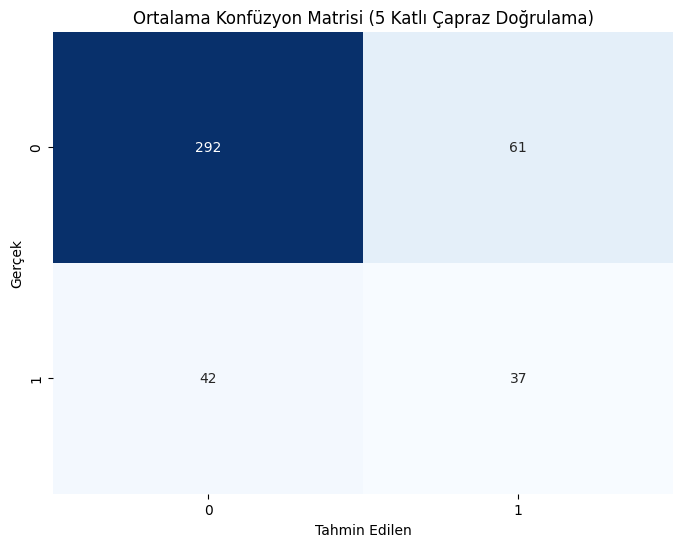

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.7609 ± 0.0213
Ortalama F1 Skoru: 0.4166 ± 0.0489
Ortalama MCC: 0.2725 ± 0.0602
Ortalama AUC-ROC: 0.7594 ± 0.0280


In [ ]:
result_xgboost_rfe = run_xgboost_model(optuna_enabled=False)

[I 2025-05-20 17:19:28,258] A new study created in memory with name: no-name-41a108e7-3400-4010-8f85-7b3c9f786c2a


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64
scale_pos_weight: 4.4861


[I 2025-05-20 17:19:29,104] Trial 0 finished with value: 0.4035135027198346 and parameters: {'eta': 0.042499618552524106, 'max_depth': 10, 'n_estimators': 323, 'subsample': 0.5833493602211985, 'colsample_bytree': 0.6323949532427365, 'min_child_weight': 8, 'gamma': 2.070759169218152, 'reg_alpha': 1.67268222675927, 'reg_lambda': 6.773193098220764}. Best is trial 0 with value: 0.4035135027198346.
[I 2025-05-20 17:19:30,363] Trial 1 finished with value: 0.3908367206133997 and parameters: {'eta': 0.03214407211764894, 'max_depth': 4, 'n_estimators': 754, 'subsample': 0.8981462505775758, 'colsample_bytree': 0.6490866376081134, 'min_child_weight': 2, 'gamma': 2.4311426424168086, 'reg_alpha': 1.729979539727442, 'reg_lambda': 4.646102605336377}. Best is trial 0 with value: 0.4035135027198346.
[I 2025-05-20 17:19:32,151] Trial 2 finished with value: 0.37769352277626933 and parameters: {'eta': 0.26732094973371934, 'max_depth': 6, 'n_estimators': 1022, 'subsample': 0.5128647642839588, 'colsample_by

En iyi parametreler: {'eta': 0.023036390936218645, 'max_depth': 9, 'n_estimators': 1214, 'subsample': 0.7468523428732425, 'colsample_bytree': 0.8106529630593101, 'min_child_weight': 8, 'gamma': 4.077543938580289, 'reg_alpha': 6.875496450443296, 'reg_lambda': 0.26288891629216704, 'objective': 'binary:logistic', 'random_state': 42, 'eval_metric': 'auc', 'scale_pos_weight': 4.4860759493670885}


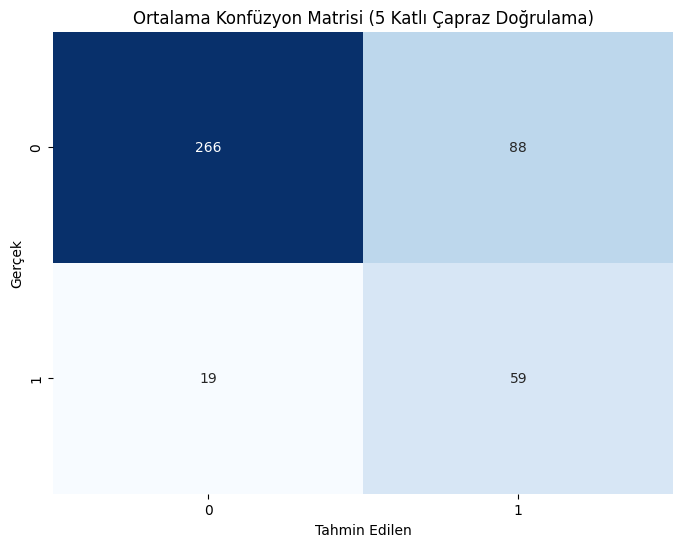

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.7517 ± 0.0108
Ortalama F1 Skoru: 0.5242 ± 0.0208
Ortalama MCC: 0.4111 ± 0.0226
Ortalama AUC-ROC: 0.8293 ± 0.0188


In [ ]:
result_xgboost_rfe_hpo = run_xgboost_model(optuna_enabled=True)

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


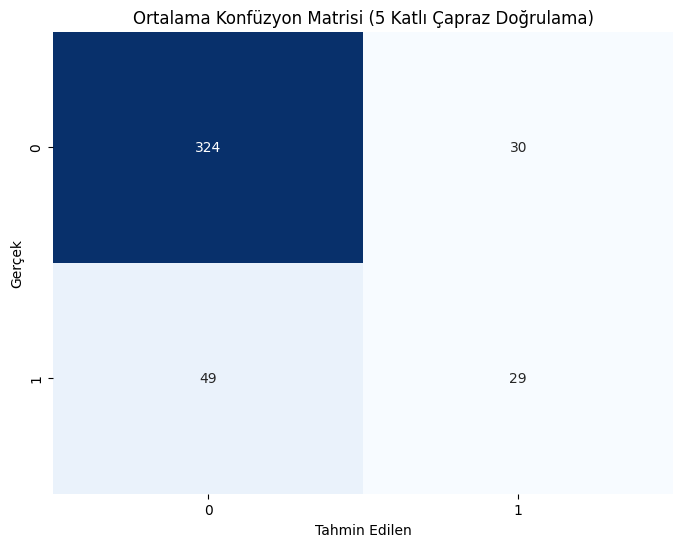

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8163 ± 0.0105
Ortalama F1 Skoru: 0.4222 ± 0.0538
Ortalama MCC: 0.3213 ± 0.0556
Ortalama AUC-ROC: 0.7425 ± 0.0230


In [ ]:
result_knn_rfe = run_knn_model_realistic(df=processed_df, optuna_enabled=False)

Bu modelde, temel KNN algoritmasına ek olarak RFE yani  yöntemi kullandık. Bu yöntemle, veri setindeki en anlamlı özellikler seçilerek model daha sade ve odaklı hale getirildi.

RFE sonrası modelin doğruluk oranı %81.6, F1 skoru 0.42, MCC değeri 0.32 ve AUC-ROC skoru 0.74 olarak gerçekleşti. Bu sonuçlar, özellikle MCC ve AUC gibi dengesiz veri setlerinde önemli olan metriklerde anlamlı değerler elde ettiğimizi gösteriyor.

Konfüzyon matrisine baktığımızda, negatif sınıfı başarılı şekilde ayırabilen bir model görüyoruz. Pozitif sınıfta ise bazı karışıklıklar olsa da, bu durum veri setindeki ciddi sınıf dengesizliğiyle açıklanabilir.

Genel olarak bu model:

Daha az özellikle daha iyi performans gösteriyor,

Aşırı öğrenme riskini azaltıyor,

Ve önceki temel KNN modeline göre daha dengeli ve kararlı sonuçlar veriyor.

Bu haliyle, hem yapısal açıdan hem de istatistiksel olarak daha güvenilir bir model elde etmiş olduk.



[I 2025-05-20 17:20:50,090] A new study created in memory with name: no-name-0077bfb6-6947-4066-a3dd-8fac3fc054ef
[I 2025-05-20 17:20:50,246] Trial 0 finished with value: 0.3659619039329054 and parameters: {'n_neighbors': 16, 'metric': 'euclidean'}. Best is trial 0 with value: 0.3659619039329054.


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


[I 2025-05-20 17:20:50,401] Trial 1 finished with value: 0.23562662151224883 and parameters: {'n_neighbors': 4, 'metric': 'euclidean'}. Best is trial 0 with value: 0.3659619039329054.
[I 2025-05-20 17:20:50,554] Trial 2 finished with value: 0.31850969268011936 and parameters: {'n_neighbors': 6, 'metric': 'euclidean'}. Best is trial 0 with value: 0.3659619039329054.
[I 2025-05-20 17:20:50,749] Trial 3 finished with value: 0.3338088487259538 and parameters: {'n_neighbors': 9, 'metric': 'manhattan'}. Best is trial 0 with value: 0.3659619039329054.
[I 2025-05-20 17:20:50,898] Trial 4 finished with value: 0.30562602578454784 and parameters: {'n_neighbors': 8, 'metric': 'minkowski'}. Best is trial 0 with value: 0.3659619039329054.
[I 2025-05-20 17:20:51,074] Trial 5 finished with value: 0.3637270717468472 and parameters: {'n_neighbors': 25, 'metric': 'euclidean'}. Best is trial 0 with value: 0.3659619039329054.
[I 2025-05-20 17:20:51,232] Trial 6 finished with value: 0.37404891328298134 and 

En iyi parametreler: {'n_neighbors': 11, 'metric': 'minkowski'}


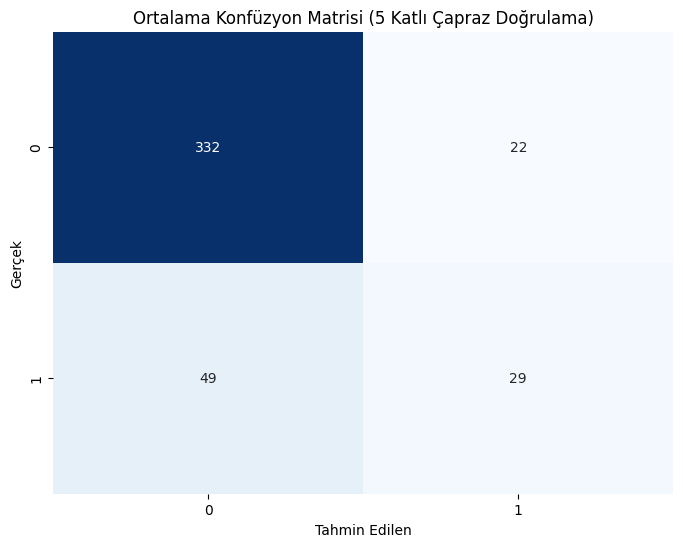

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8357 ± 0.0091
Ortalama F1 Skoru: 0.4545 ± 0.0428
Ortalama MCC: 0.3758 ± 0.0440
Ortalama AUC-ROC: 0.7933 ± 0.0164


In [ ]:
result_knn_rfe_hpo = run_knn_model_realistic(df=processed_df, optuna_enabled=True)

Bu sonuçlar, özellikle dengesiz veri setlerinde önemli olan MCC ve AUC gibi metriklerde kayda değer bir başarıya ulaşıldığını gösterir.

Konfüzyon matrisi incelendiğinde, modelin negatif sınıfı oldukça başarılı şekilde ayırt ettiği gözlemlenmektedir. Pozitif sınıfta ise belirli karışıklıklar söz konusudur. Ancak bu durum, veri setinde gözlemlenen belirgin sınıf dengesizliğinden kaynaklanmaktadır.

Genel olarak bu model:

Daha az sayıda fakat anlamlı özellik ile daha iyi performans göstermektedir,

Aşırı öğrenme (overfitting) riskini azaltmaktadır,

Temel KNN modeline kıyasla daha dengeli ve kararlı sonuçlar vermektedir.

Bu bağlamda, hem yapısal hem de istatistiksel olarak daha güvenilir bir model elde edildiği söylenebilir.

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


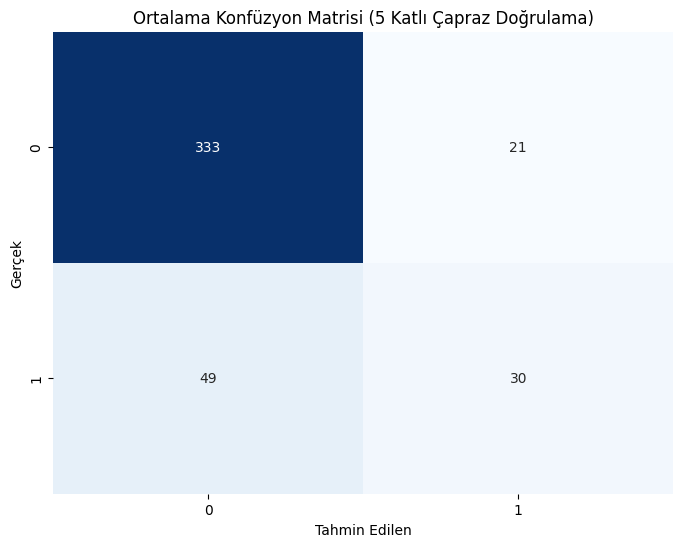

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8380 ± 0.0086
Ortalama F1 Skoru: 0.4595 ± 0.0376
Ortalama MCC: 0.3821 ± 0.0397
Ortalama AUC-ROC: 0.7190 ± 0.0538


In [ ]:
result_svm_rfe = run_svm_model(processed_df, optuna_enabled=False)

[I 2025-05-20 17:20:59,640] A new study created in memory with name: svm_study_2336


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


[I 2025-05-20 17:21:03,472] Trial 0 finished with value: 0.38212788605073944 and parameters: {'C': 5.07768052261896}. Best is trial 0 with value: 0.38212788605073944.
[I 2025-05-20 17:21:04,708] Trial 1 finished with value: 0.38212788605073944 and parameters: {'C': 0.29530914088802246}. Best is trial 0 with value: 0.38212788605073944.
[I 2025-05-20 17:21:06,236] Trial 2 finished with value: 0.38212788605073944 and parameters: {'C': 0.8626748484350582}. Best is trial 0 with value: 0.38212788605073944.
[I 2025-05-20 17:21:09,440] Trial 3 finished with value: 0.38212788605073944 and parameters: {'C': 4.96712685064897}. Best is trial 0 with value: 0.38212788605073944.
[I 2025-05-20 17:21:14,399] Trial 4 finished with value: 0.38212788605073944 and parameters: {'C': 7.34876379982817}. Best is trial 0 with value: 0.38212788605073944.
[I 2025-05-20 17:21:15,982] Trial 5 finished with value: 0.38212788605073944 and parameters: {'C': 0.9267677584693544}. Best is trial 0 with value: 0.3821278860

En iyi parametreler: {'C': 5.07768052261896, 'random_state': 42, 'probability': True}


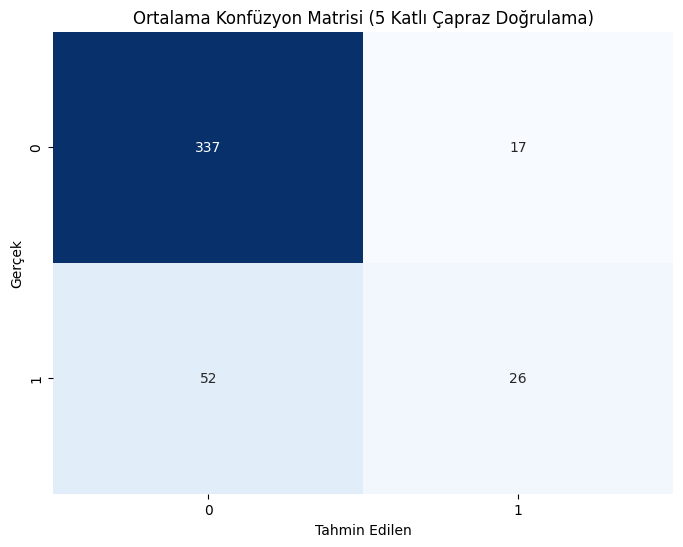

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8385 ± 0.0105
Ortalama F1 Skoru: 0.4265 ± 0.0440
Ortalama MCC: 0.3626 ± 0.0434
Ortalama AUC-ROC: 0.7710 ± 0.0199


In [ ]:
result_svm_rfe_hpo = run_svm_model(processed_df, optuna_enabled=True)

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


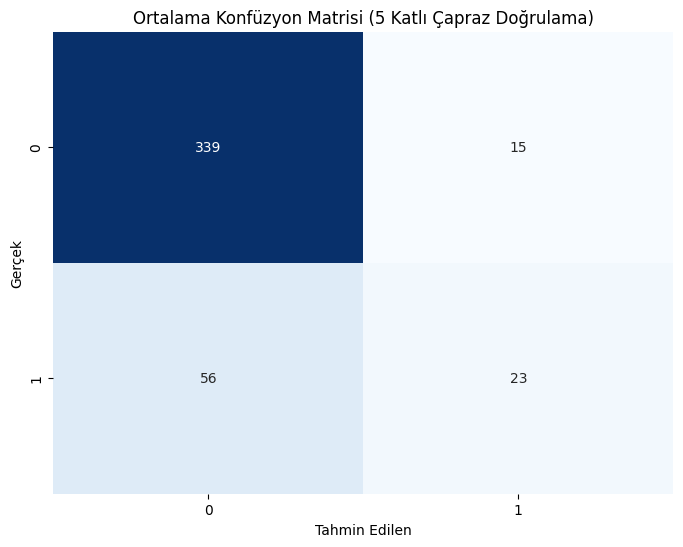

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8362 ± 0.0076
Ortalama F1 Skoru: 0.3926 ± 0.0276
Ortalama MCC: 0.3393 ± 0.0314
Ortalama AUC-ROC: 0.8171 ± 0.0255


In [ ]:
result_lr_rfe = run_logistic_regression_model(processed_df, optuna_enabled=False)

[I 2025-05-20 17:21:20,557] A new study created in memory with name: no-name-e82d9d03-ef85-480f-b45b-4165d8df8c41
[I 2025-05-20 17:21:20,633] Trial 0 finished with value: 0.34904850770249063 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.2576107173675883, 'tol': 1.034508564890764e-05}. Best is trial 0 with value: 0.34904850770249063.
[I 2025-05-20 17:21:20,710] Trial 1 finished with value: 0.3367512931054725 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.37114309829568176, 'tol': 7.610050423743584e-05}. Best is trial 0 with value: 0.34904850770249063.


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64


[I 2025-05-20 17:21:20,806] Trial 2 finished with value: 0.33931560610295286 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 5.5344293829062154, 'tol': 7.272349213067854e-05}. Best is trial 0 with value: 0.34904850770249063.
[I 2025-05-20 17:21:20,876] Trial 3 finished with value: 0.3431602514175318 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.27125495808815997, 'tol': 4.0113094647816555e-05}. Best is trial 0 with value: 0.34904850770249063.
[I 2025-05-20 17:21:20,877] Trial 4 pruned. 
[I 2025-05-20 17:21:20,935] Trial 5 finished with value: 0.3716666762971855 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.02369657852927814, 'tol': 3.080832707061448e-05}. Best is trial 5 with value: 0.3716666762971855.
[I 2025-05-20 17:21:21,205] Trial 6 finished with value: 0.33771914224464916 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 5.313614721179359, 'tol': 6.245719587684164e-05}. Best is trial 5 with value: 0.3716666762971855.
[I 20

En iyi parametreler: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.017235577889618613, 'tol': 0.0002438325432812115, 'max_iter': 1000, 'random_state': 42}


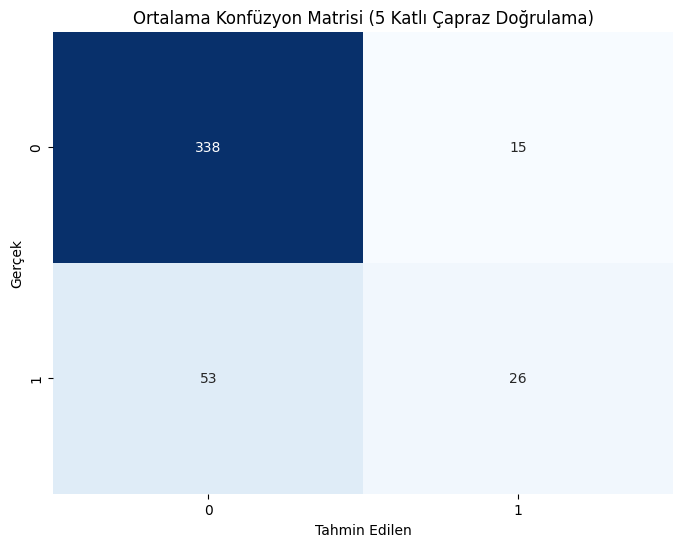

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.8417 ± 0.0064
Ortalama F1 Skoru: 0.4302 ± 0.0279
Ortalama MCC: 0.3732 ± 0.0250
Ortalama AUC-ROC: 0.7831 ± 0.0322


In [ ]:
result_lr_rfe_hpo = run_logistic_regression_model(processed_df, optuna_enabled=True)

Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64
class_weight: balanced


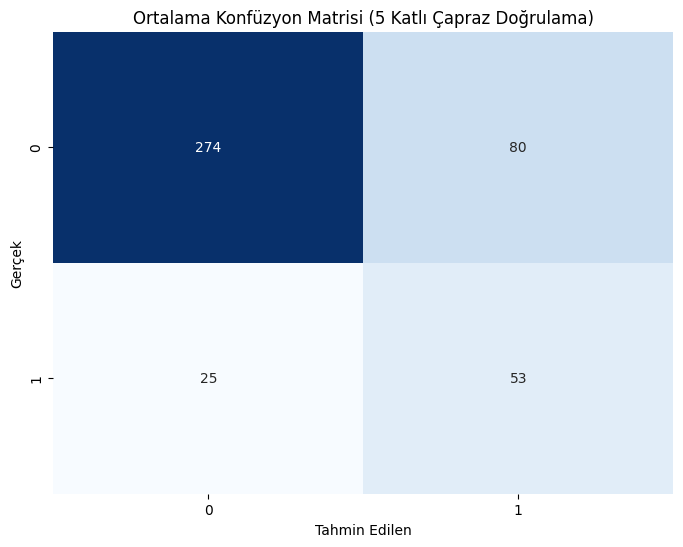

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.7568 ± 0.0189
Ortalama F1 Skoru: 0.5040 ± 0.0454
Ortalama MCC: 0.3797 ± 0.0525
Ortalama AUC-ROC: 0.8153 ± 0.0215


In [ ]:
result_rf_rfe = run_random_forest_model(optuna_enabled=False)

[I 2025-05-20 17:21:33,652] A new study created in memory with name: no-name-cb016d14-d98b-4749-beb9-ad5e904a1ccb


Sınıf frekansları:
 housingComplex
0    1772
1     395
Name: count, dtype: int64
class_weight: balanced


[I 2025-05-20 17:21:48,549] Trial 0 finished with value: 0.38387343571123544 and parameters: {'n_estimators': 1493, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.38387343571123544.
[I 2025-05-20 17:21:56,759] Trial 1 finished with value: 0.3839692089911013 and parameters: {'n_estimators': 511, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.3839692089911013.
[I 2025-05-20 17:22:04,657] Trial 2 finished with value: 0.3588861043696824 and parameters: {'n_estimators': 557, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.3839692089911013.
[I 2025-05-20 17:22:07,707] Trial 3 finished with value: 0.4018422828729797 and parameters: {'n_estimators': 307, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features':

En iyi parametreler: {'n_estimators': 963, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True, 'random_state': 42, 'class_weight': 'balanced'}


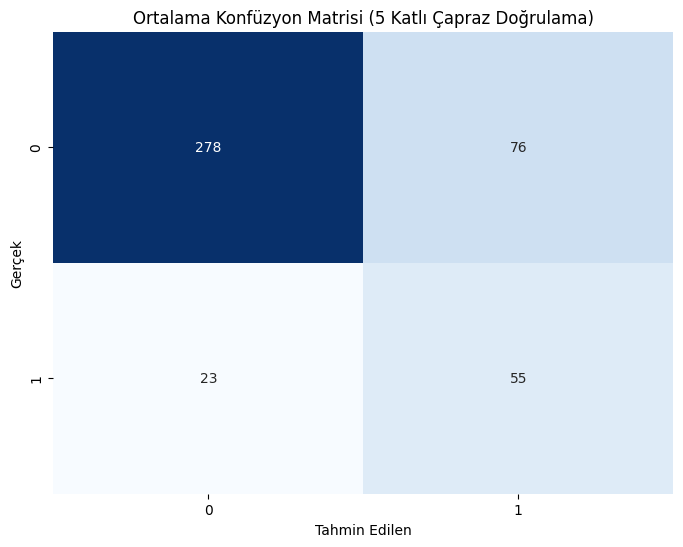

5 Katlı Çapraz Doğrulama Ortalama Skorları:
Ortalama Doğruluk: 0.7706 ± 0.0046
Ortalama F1 Skoru: 0.5276 ± 0.0280
Ortalama MCC: 0.4116 ± 0.0307
Ortalama AUC-ROC: 0.8241 ± 0.0155


In [ ]:
result_rf_rfe_optuna = run_random_forest_model(optuna_enabled=True)

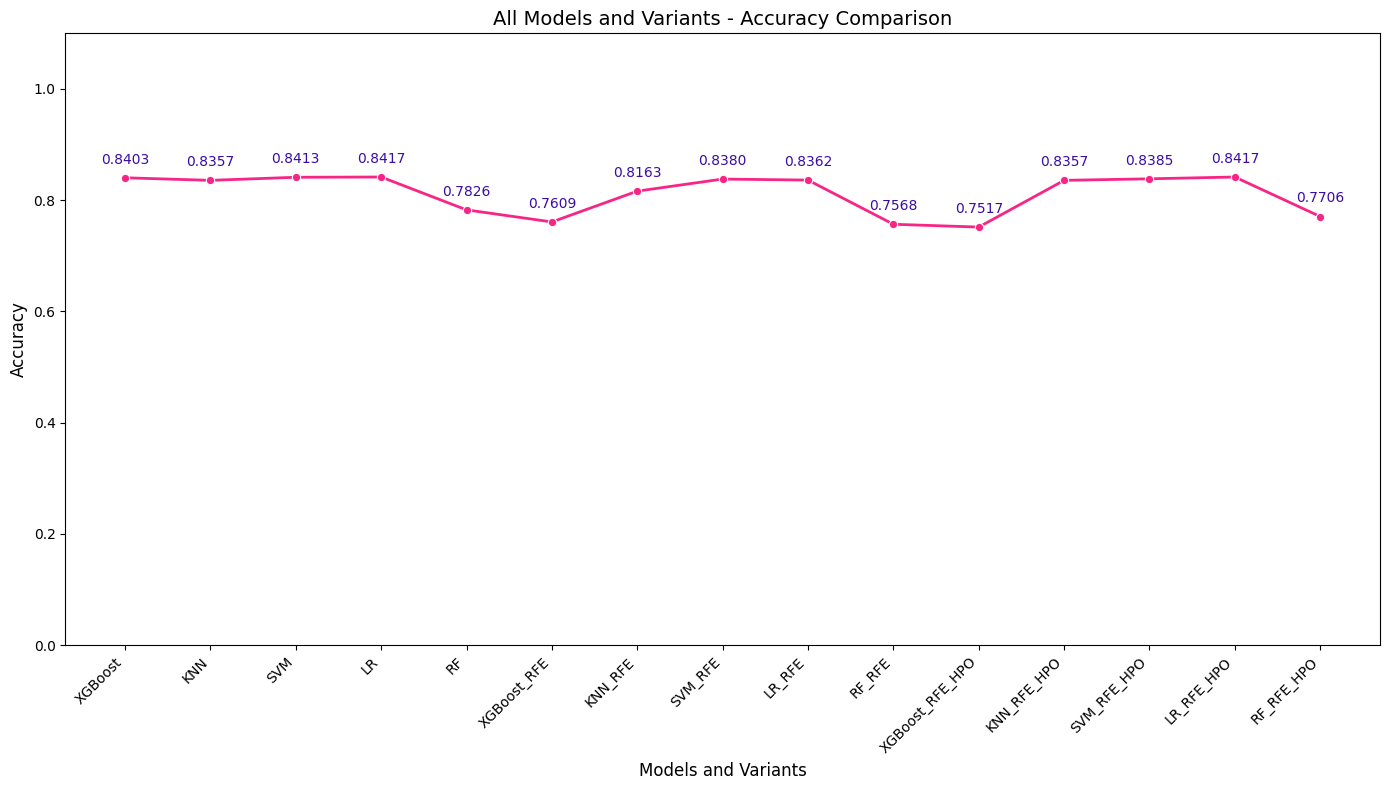

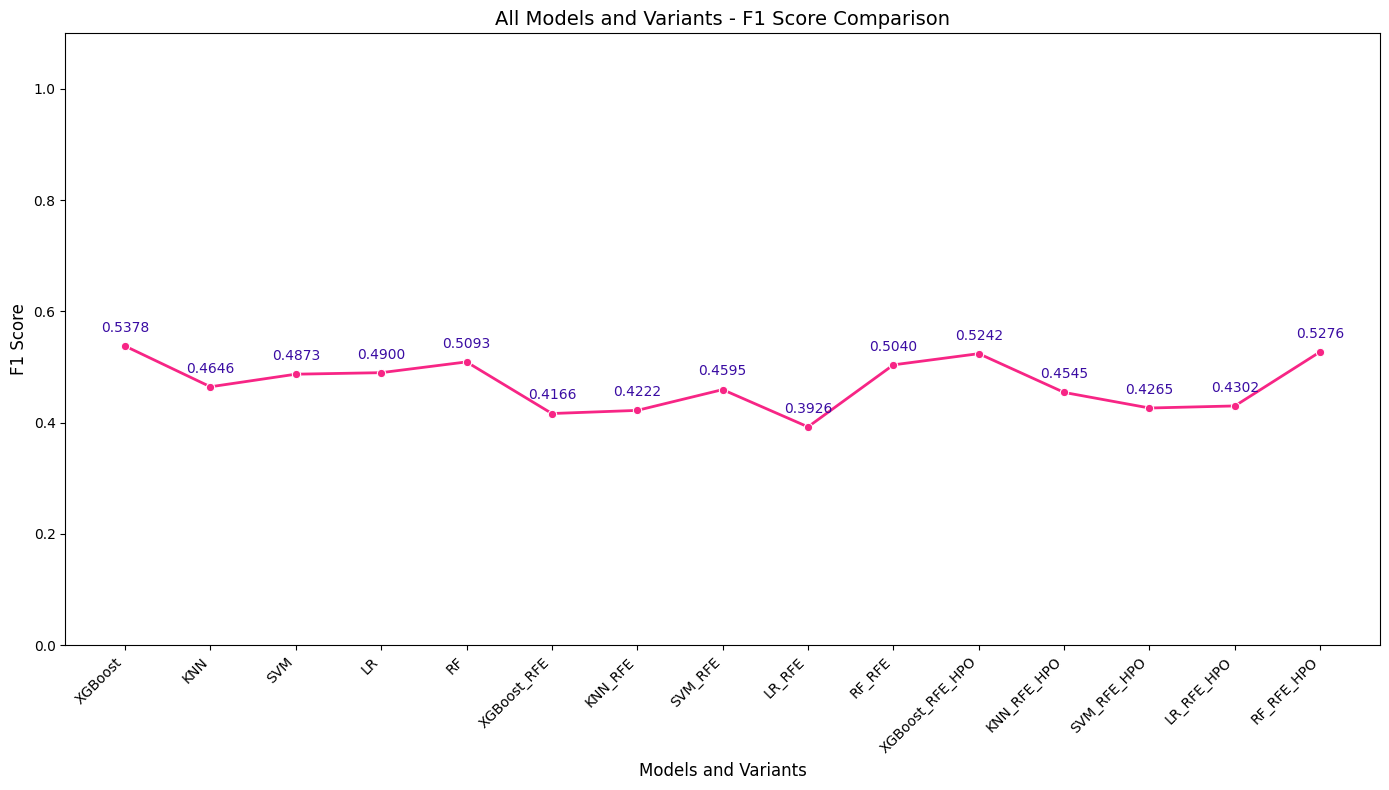

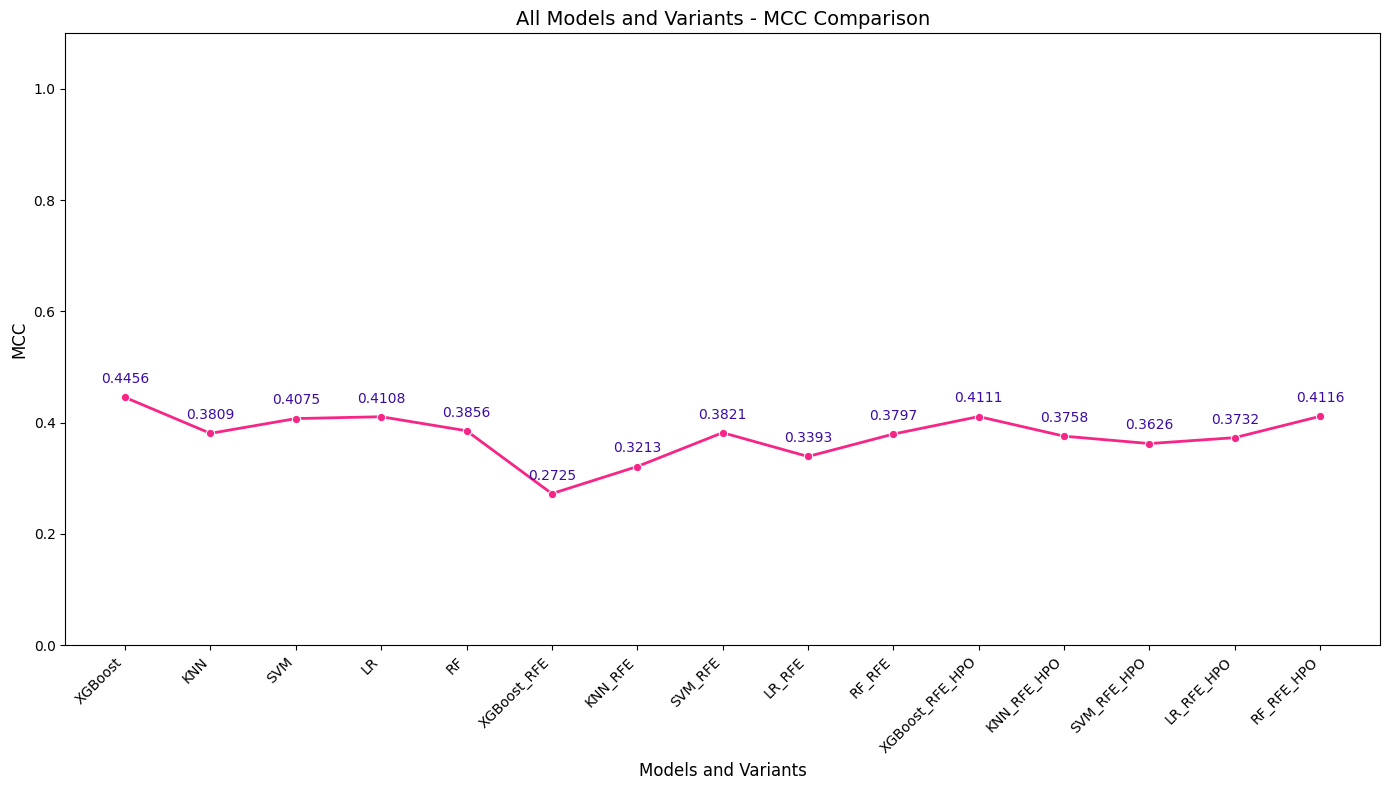

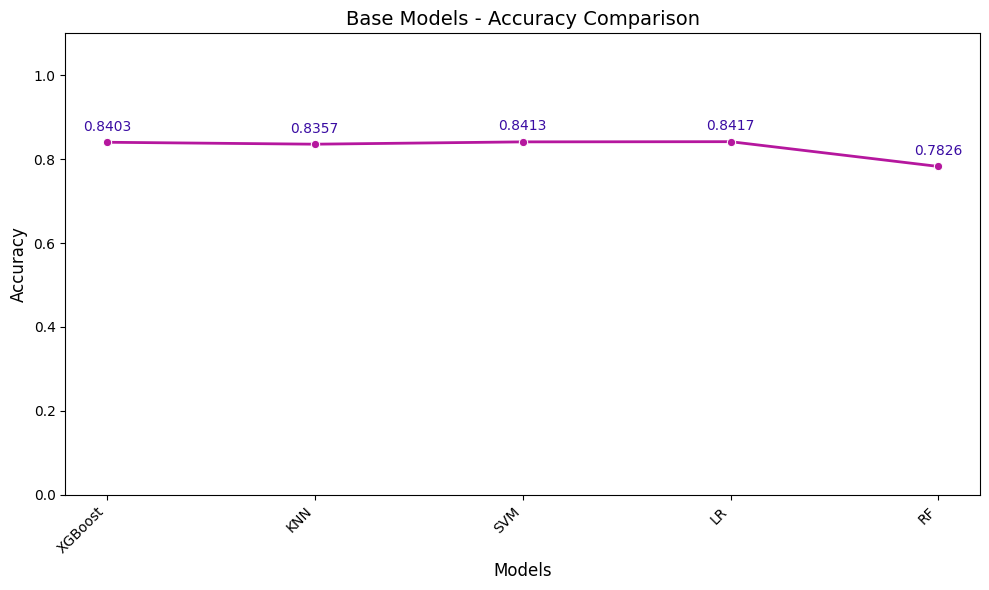

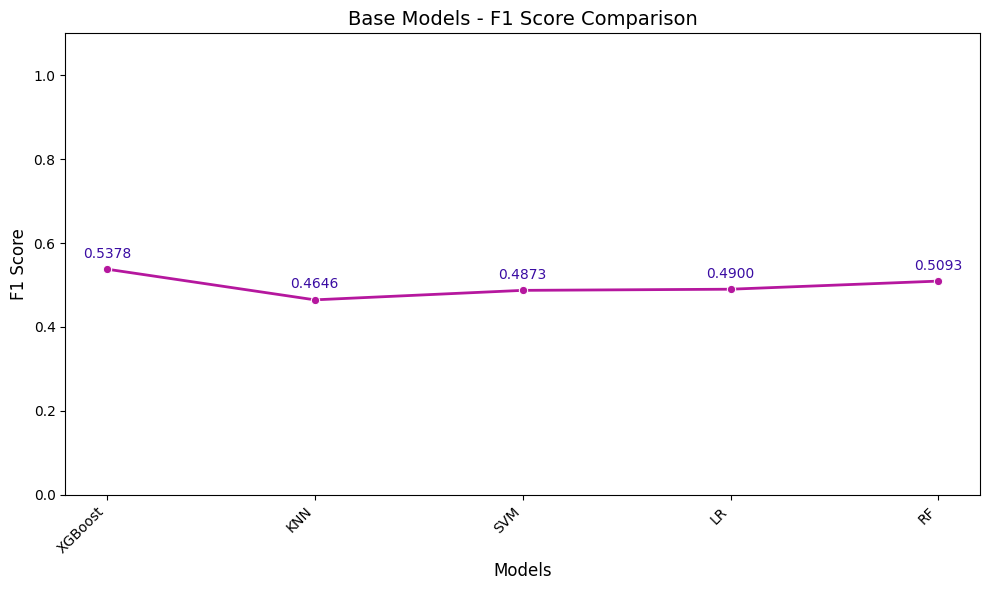

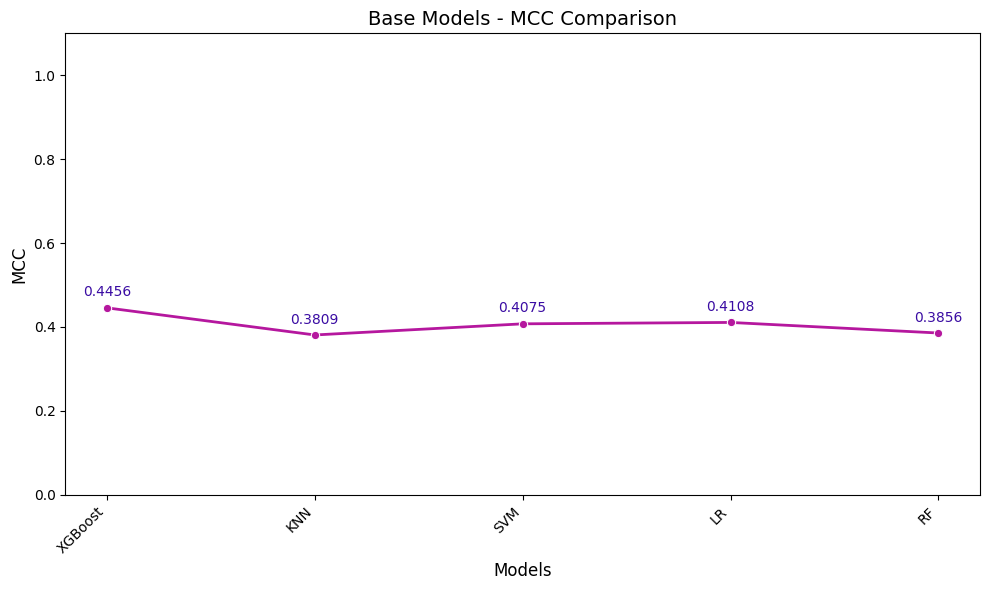

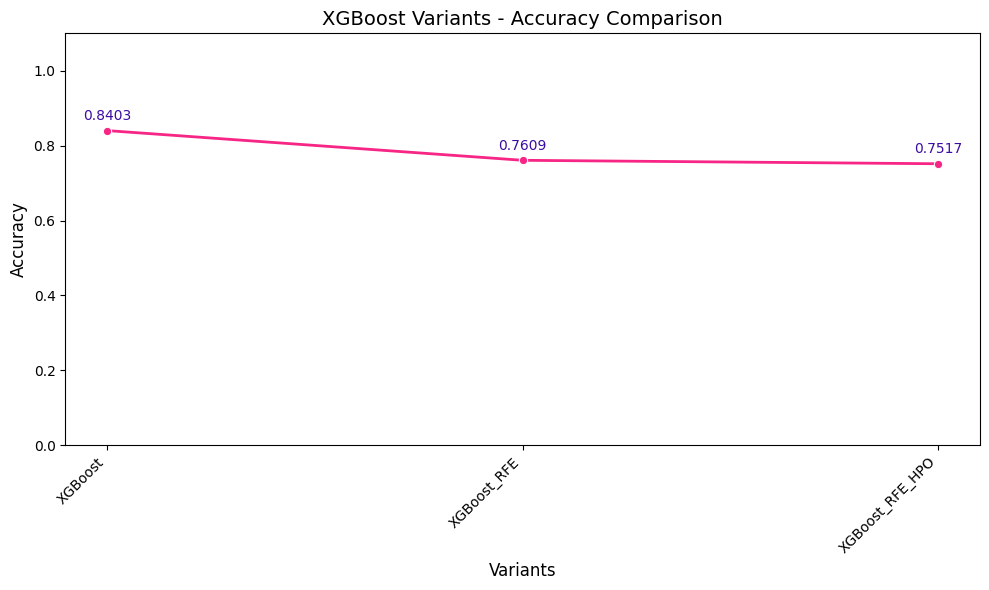

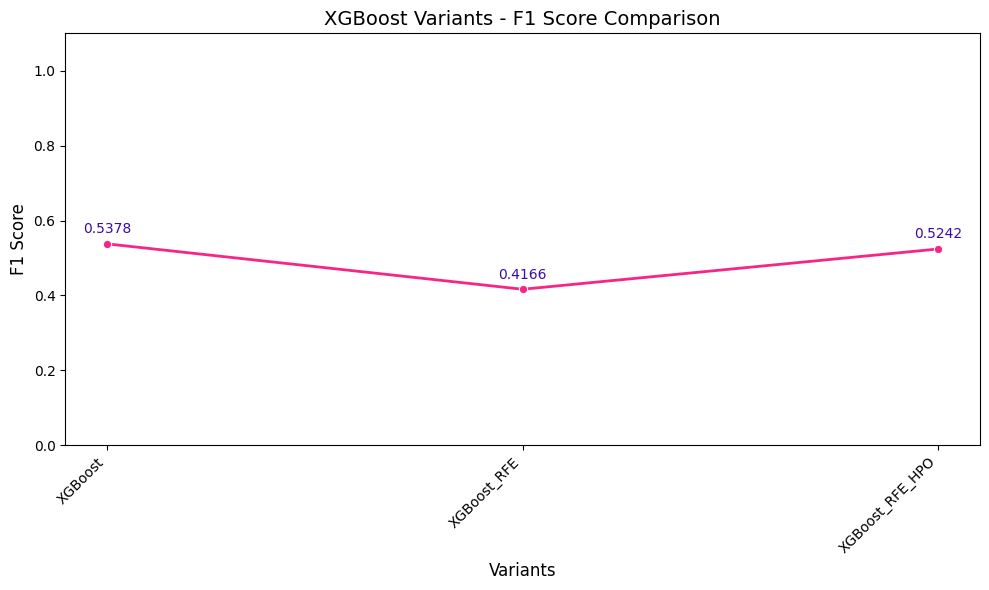

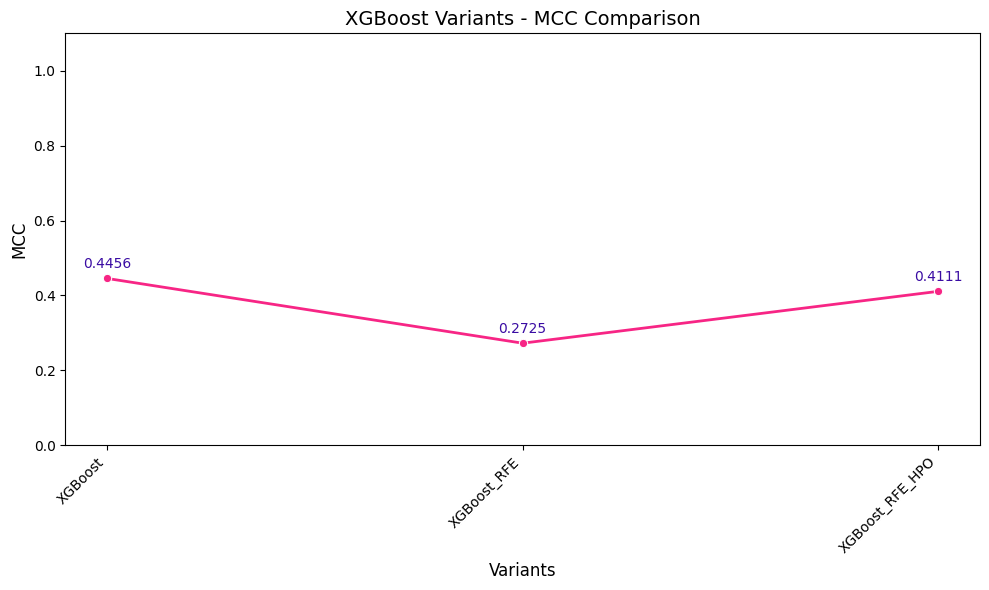

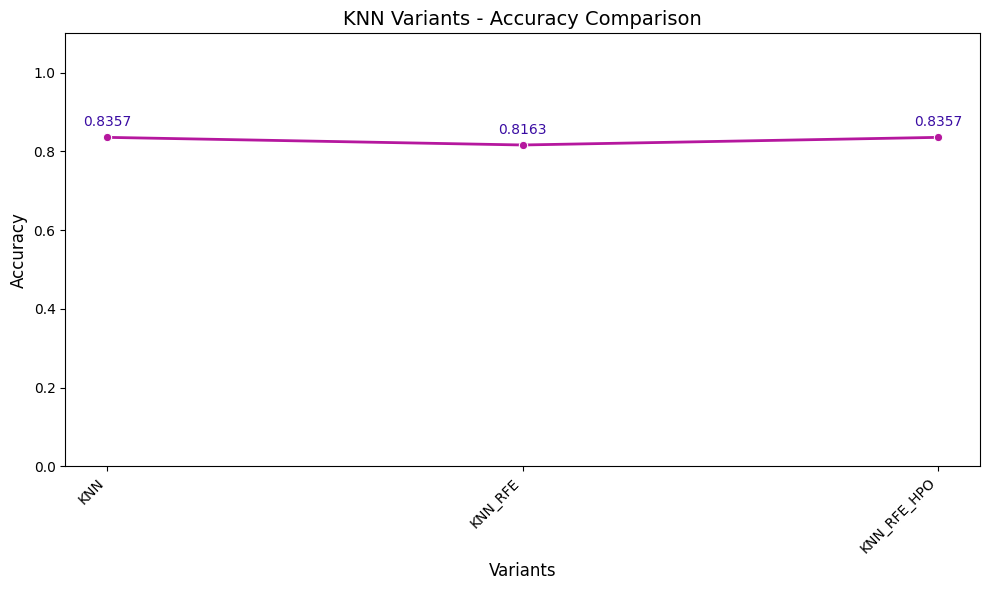

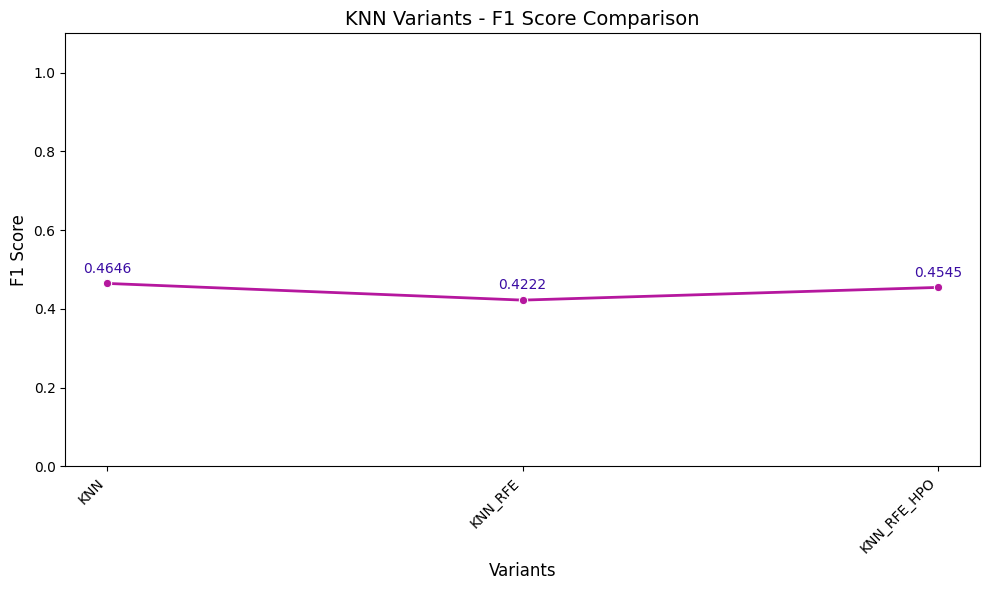

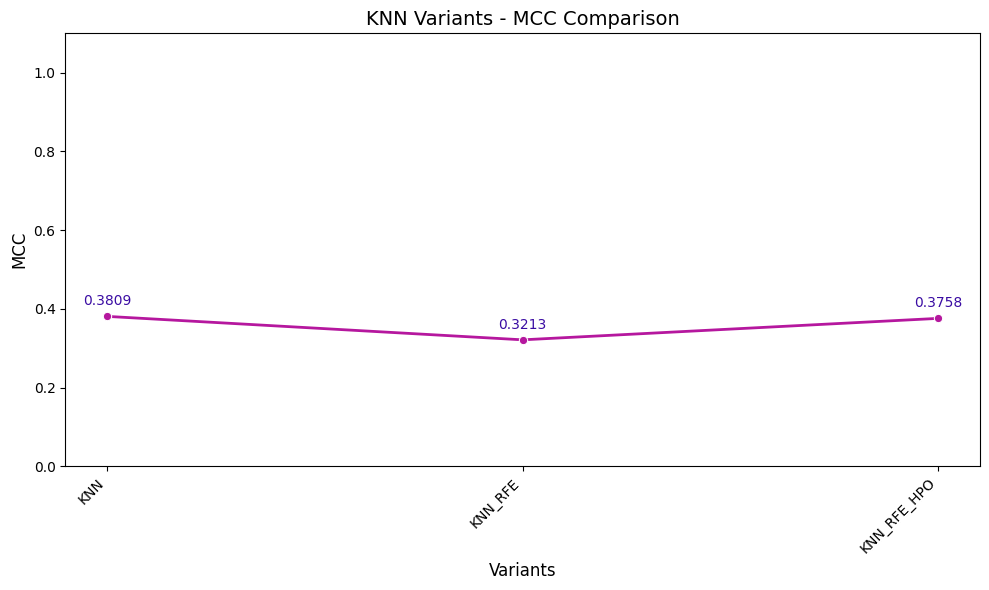

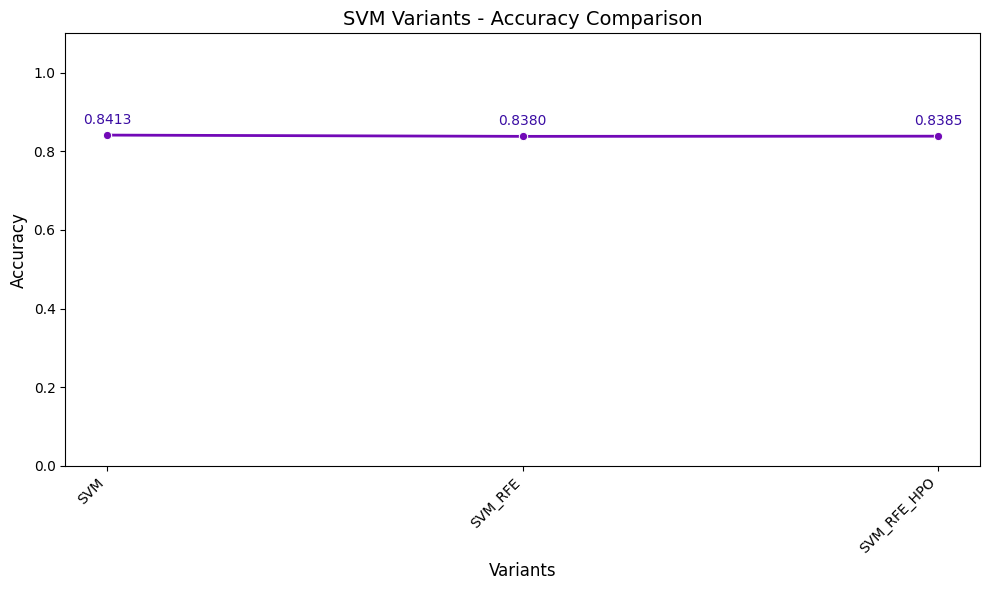

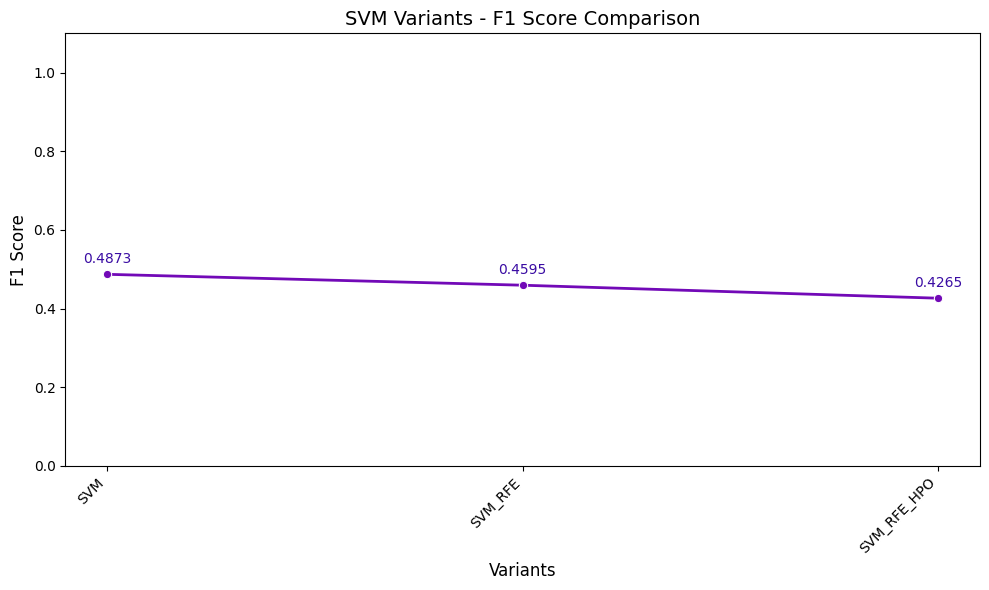

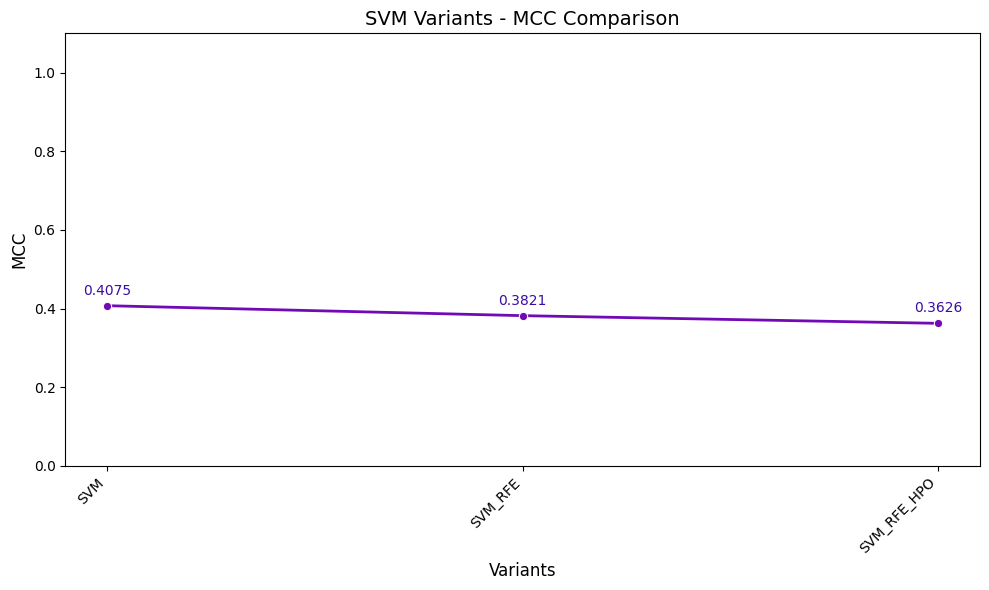

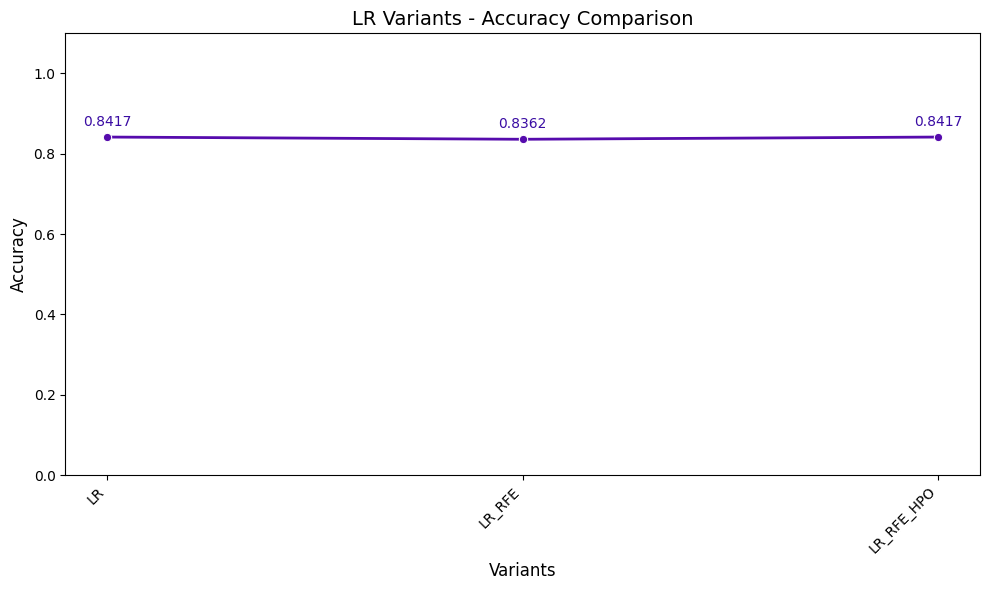

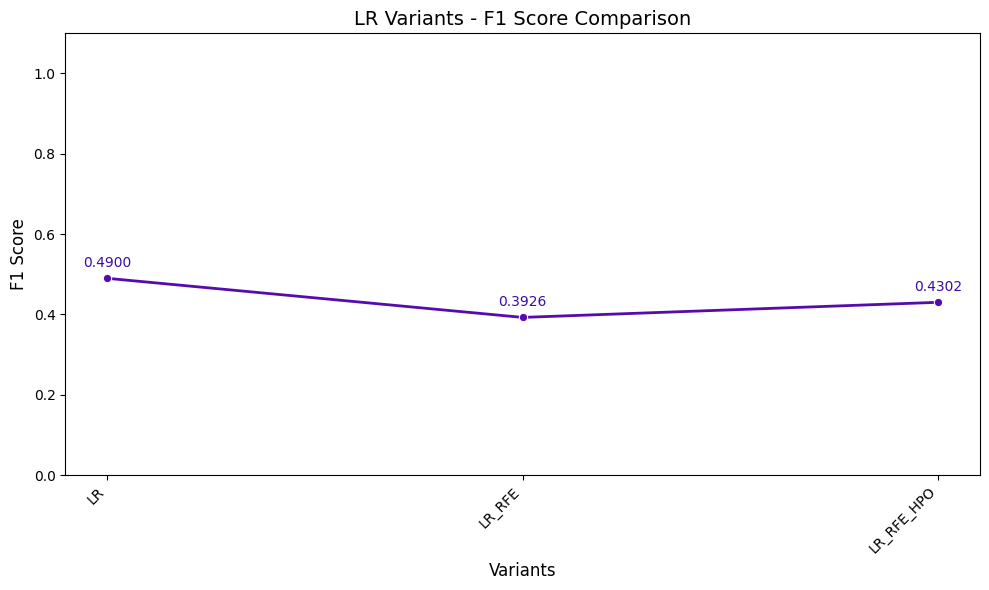

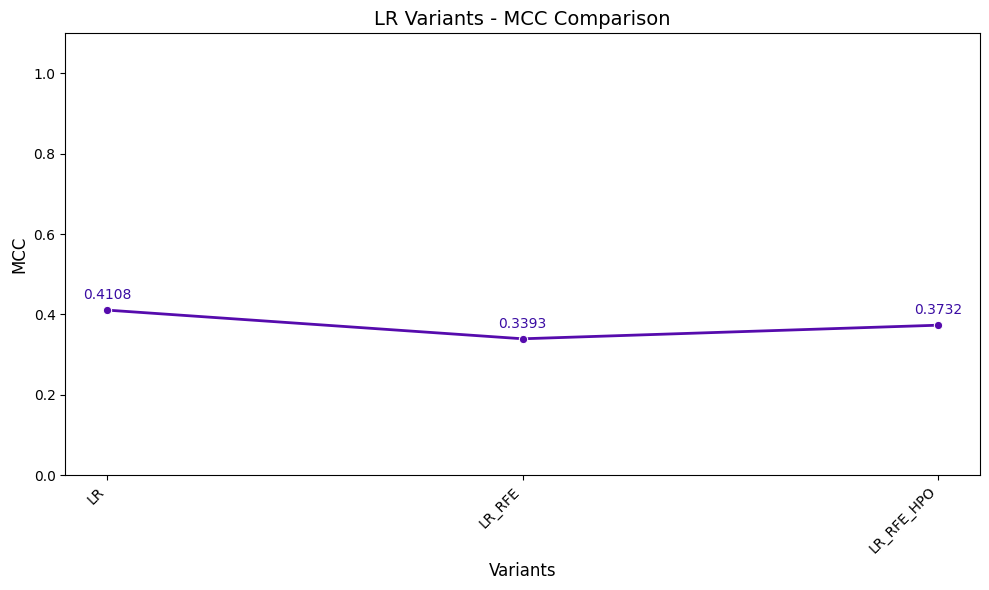

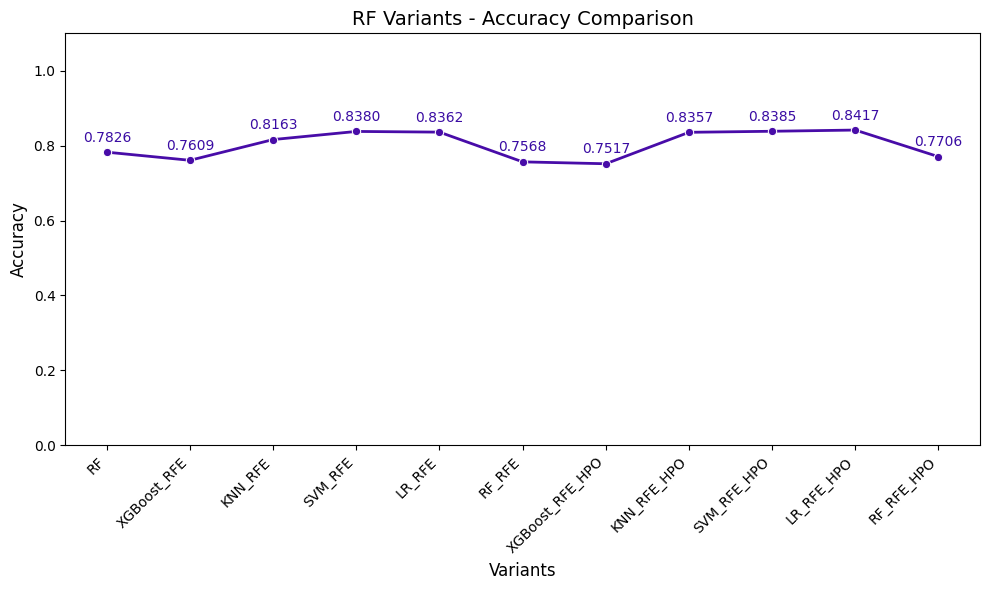

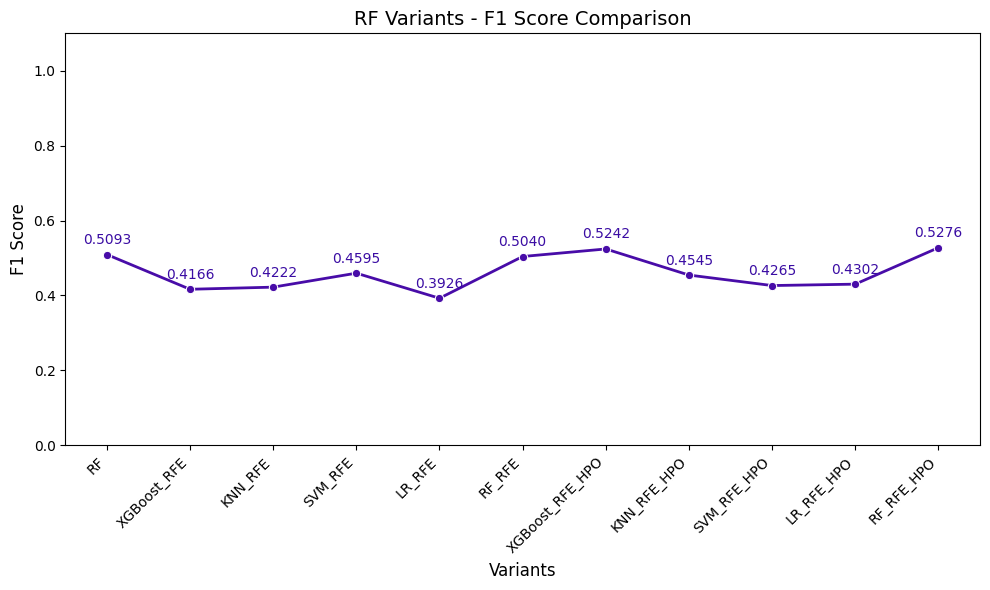

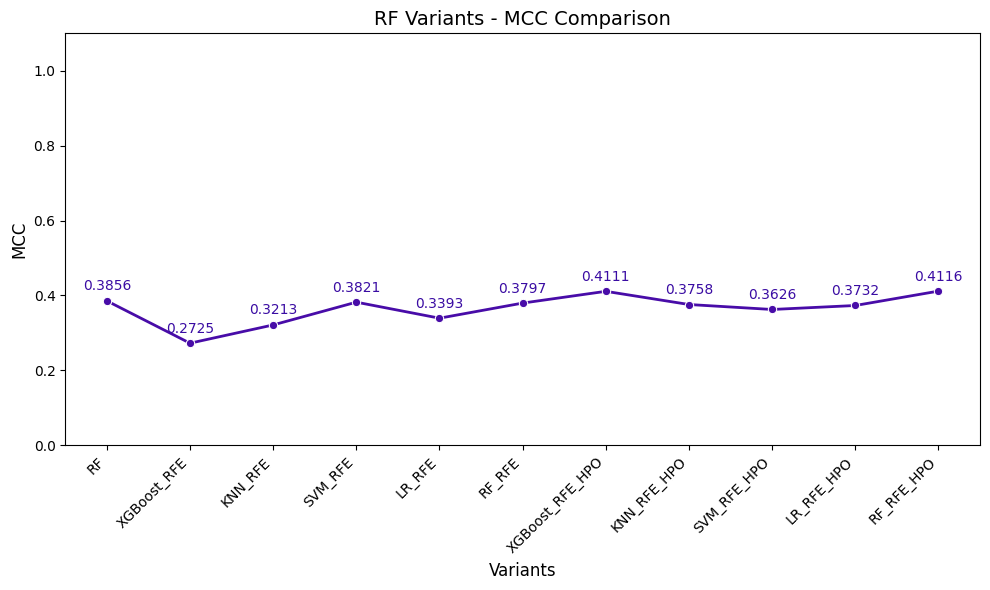

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Synthwave palette
def set_synthwave_palette():
    return ['#f72585', '#b5179e', '#7209b7', '#560bad', '#480ca8',
            '#3a0ca3', '#3f37c9', '#4361ee', '#4895ef', '#4cc9f0']

# Visualization function for Accuracy, F1 Score, MCC metrics using line plots
def plot_model_metrics_extended(results_dict, metrics=None, save_dir='.', palette=None):
    if metrics is None:
        metrics = ['Accuracy', 'F1 Score', 'MCC']

    if palette is None:
        palette = set_synthwave_palette()

    # Combine results into a single DataFrame
    combined_df = pd.concat([df for df in results_dict.values() if df is not None], axis=0)
    combined_df.index = [key for key, df in results_dict.items() if df is not None]
    combined_df = combined_df[metrics]  # Select only specified metrics

    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # 1. All Models and Variants Comparison
    for metric in metrics:
        plt.figure(figsize=(14, 8))
        sns.lineplot(x=combined_df.index, y=combined_df[metric], marker='o', color=palette[0], linewidth=2)
        plt.title(f'All Models and Variants - {metric} Comparison', fontsize=14)
        plt.ylabel(metric, fontsize=12)
        plt.xlabel('Models and Variants', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1.1)  # Metrics are typically between 0 and 1

        # Add value labels
        for i, v in enumerate(combined_df[metric]):
            plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', color='#3a0ca3')

        plt.tight_layout()
        plt.savefig(f'{save_dir}/all_models_{metric}_line_comparison.png')
        plt.show()
        plt.close()

    # 2. Base Models Comparison (No RFE, No HPO)
    base_models = [k for k in results_dict.keys() if 'RFE' not in k and 'HPO' not in k]
    base_df = combined_df.loc[base_models]

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=base_df.index, y=base_df[metric], marker='o', color=palette[1], linewidth=2)
        plt.title(f'Base Models - {metric} Comparison', fontsize=14)
        plt.ylabel(metric, fontsize=12)
        plt.xlabel('Models', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1.1)

        # Add value labels
        for i, v in enumerate(base_df[metric]):
            plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', color='#3a0ca3')

        plt.tight_layout()
        plt.savefig(f'{save_dir}/base_models_{metric}_line_comparison.png')
        plt.show()
        plt.close()

    # 3. Model Variants Comparison (Each model's variations)
    model_groups = {
        'XGBoost': [k for k in results_dict.keys() if 'XGBoost' in k],
        'KNN': [k for k in results_dict.keys() if 'KNN' in k],
        'SVM': [k for k in results_dict.keys() if 'SVM' in k],
        'LR': [k for k in results_dict.keys() if 'LR' in k],
        'RF': [k for k in results_dict.keys() if 'RF' in k]
    }

    for model, model_keys in model_groups.items():
        if not model_keys:
            continue
        model_df = combined_df.loc[model_keys]

        for metric in metrics:
            plt.figure(figsize=(10, 6))
            sns.lineplot(x=model_df.index, y=model_df[metric], marker='o',
                         color=palette[list(model_groups.keys()).index(model) % len(palette)], linewidth=2)
            plt.title(f'{model} Variants - {metric} Comparison', fontsize=14)
            plt.ylabel(metric, fontsize=12)
            plt.xlabel('Variants', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.ylim(0, 1.1)

            # Add value labels
            for i, v in enumerate(model_df[metric]):
                plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', color='#3a0ca3')

            plt.tight_layout()
            plt.savefig(f'{save_dir}/{model}_{metric}_line_variants_comparison.png')
            plt.show()
            plt.close()

# Results dictionary (including Random Forest)
results_dict = {
    'XGBoost': result_xgboost,
    'KNN': result_knn,
    'SVM': result_svm,
    'LR': result_lr,
    'RF': result_rf,
    'XGBoost_RFE': result_xgboost_rfe,
    'KNN_RFE': result_knn_rfe,
    'SVM_RFE': result_svm_rfe,
    'LR_RFE': result_lr_rfe,
    'RF_RFE': result_rf_rfe,
    'XGBoost_RFE_HPO': result_xgboost_rfe_hpo,
    'KNN_RFE_HPO': result_knn_rfe_hpo,
    'SVM_RFE_HPO': result_svm_rfe_hpo,
    'LR_RFE_HPO': result_lr_rfe_hpo,
    'RF_RFE_HPO': result_rf_rfe_optuna
}

# Run visualization
plot_model_metrics_extended(
    results_dict,
    metrics=['Accuracy', 'F1 Score', 'MCC'],
    save_dir='comparisons',
    palette=set_synthwave_palette()
)